# ICA Analysis: Investigating Delta-Band Over-Reliance in FAST

## Motivation
SHAP analysis on the FAST model revealed that delta-band (0.5–4 Hz) activity dominates the
model's decision-making. The model also overfits severely and does not generalize across subjects.

**Core question**: Is the delta dominance driven by **artifact contamination** (eye blinks, slow
drifts, movement) or by **genuine neural slow cortical potentials**?

## Approach
1. Load the raw EEG data from the HDF5 cache.
2. Construct MNE `RawArray` objects with proper electrode montage.
3. Run ICA decomposition per subject.
4. Characterize each IC: spectral profile, topography, variance explained.
5. Identify delta-dominant components and classify them as artifact vs. neural.
6. Visualize the findings to guide preprocessing improvements.

# 1. Imports & Configuration

In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import signal

import mne
from mne.preprocessing import ICA

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --------------------------------------------------------------------------
# Project paths
# --------------------------------------------------------------------------
PROJECT_ROOT = '/home/kay/FAST'
H5_TRAIN = os.path.join(PROJECT_ROOT, 'Processed', 'BCIC2020Track3.h5')
H5_TEST  = os.path.join(PROJECT_ROOT, 'Processed', 'BCIC2020Track3_Test.h5')

# --------------------------------------------------------------------------
# Dataset constants (from src/fast/data/preprocess.py)
# --------------------------------------------------------------------------
SFREQ = 250  # Sampling rate in Hz

ELECTRODES = [
    'Fp1','Fp2','F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6','T7','C3','Cz','C4',
    'T8','TP9','CP5','CP1','CP2','CP6','TP10','P7','P3','Pz','P4','P8','PO9','O1','Oz',
    'O2','PO10','AF7','AF3','AF4','AF8','F5','F1','F2','F6','FT9','FT7','FC3','FC4','FT8',
    'FT10','C5','C1','C2','C6','TP7','CP3','CPz','CP4','TP8','P5','P1','P2','P6','PO7',
    'PO3','POz','PO4','PO8'
]

ZONES = {
    'Pre-frontal': ['AF7','Fp1','Fp2','AF8','AF3','AF4'],
    'Frontal':     ['F7','F5','F3','F1','Fz','F2','F4','F6','F8'],
    'Pre-central': ['FC1','FC2','FC3','FC4','FC5','FC6'],
    'Central':     ['C1','C2','C3','Cz','C4','C5','C6'],
    'Post-central':['CP1','CP2','CP3','CPz','CP4','CP5','CP6'],
    'Temporal':    ['T7','T8','FT7','FT8','TP7','TP8','TP9','TP10','FT9','FT10'],
    'Parietal':    ['P1','P2','P3','P4','Pz','P5','P6','P7','P8','PO3','PO4','PO7','PO8','PO9','PO10'],
    'Occipital':   ['O1','O2','Oz','POz'],
}

CLASSES = ['hello', 'help-me', 'stop', 'thank-you', 'yes']
N_CHANNELS = len(ELECTRODES)  # 64
N_SUBJECTS = 15

# Frequency band definitions
BANDS = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta':  (13, 30),
    'Gamma': (30, 45),
}

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
matplotlib.rcParams['figure.dpi'] = 120

print(f"MNE version     : {mne.__version__}")
print(f"Channels        : {N_CHANNELS}")
print(f"Sampling rate   : {SFREQ} Hz")
print(f"Train H5 exists : {os.path.exists(H5_TRAIN)}")
print(f"Test  H5 exists : {os.path.exists(H5_TEST)}")
print("Setup complete.")

MNE version     : 1.11.0
Channels        : 64
Sampling rate   : 250 Hz
Train H5 exists : True
Test  H5 exists : True
Setup complete.


# 2. Data Loading & MNE Object Construction

We load the preprocessed HDF5 data and convert it into MNE `RawArray` objects.
Each subject's trials are concatenated into a continuous signal for ICA stability.
We also attach a standard 10-20 montage for topographic plotting.

In [2]:
def load_h5_per_subject(h5_path):
    """Load the HDF5 cache and return a dict {subject_id: (X, Y)}.
    
    X shape per subject: (n_trials, 64, 800)
    Y shape per subject: (n_trials,)
    """
    data = {}
    with h5py.File(h5_path, 'r') as f:
        for sid in sorted(f.keys()):
            X = f[sid]['X'][()]   # (trials, channels, timepoints)
            Y = f[sid]['Y'][()]   # (trials,)
            data[sid] = (X.astype(np.float32), Y.astype(np.int64))
            print(f"  Subject {sid}: X{X.shape}, Y{Y.shape}, "
                  f"labels={np.unique(Y)}, "
                  f"X range=[{X.min():.1f}, {X.max():.1f}]")
    return data


def build_mne_raw(X_subject, sfreq=SFREQ, ch_names=None):
    """Convert a subject's trial matrix into an MNE RawArray.
    
    Trials are concatenated along the time axis to form a continuous signal,
    which is the standard input format for ICA.
    
    Args:
        X_subject: (n_trials, n_channels, n_timepoints)
        sfreq: sampling frequency
        ch_names: list of channel names
        
    Returns:
        mne.io.RawArray with standard_1020 montage attached.
    """
    if ch_names is None:
        ch_names = ELECTRODES
    
    # Concatenate all trials along time axis: (n_channels, n_trials * n_timepoints)
    continuous = np.concatenate(X_subject, axis=1)
    
    # MNE expects data in Volts; our data is in microvolts.
    # Scale factor: 1e-6 (µV → V)
    continuous_volts = continuous * 1e-6
    
    # Create MNE Info and RawArray
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(continuous_volts, info, verbose=False)
    
    # Attach standard 10-20 montage for topographic maps
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='warn')
    
    return raw


# --------------------------------------------------------------------------
# Load training data
# --------------------------------------------------------------------------
print("Loading training data (train+validation combined)...")
train_data = load_h5_per_subject(H5_TRAIN)

print(f"\nLoaded {len(train_data)} subjects.")
print(f"Trials per subject: {train_data['01'][0].shape[0]}")
print(f"Channels: {train_data['01'][0].shape[1]}, Timepoints: {train_data['01'][0].shape[2]}")

Loading training data (train+validation combined)...
  Subject 01: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-1472.8, 670.7]
  Subject 02: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-1439.0, 1762.8]
  Subject 03: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-793.2, 953.4]
  Subject 04: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-1656.4, 3537.3]
  Subject 05: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-788.3, 1121.5]
  Subject 06: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-3276.9, 3281.2]
  Subject 07: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-1376.0, 3127.3]
  Subject 08: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-968.5, 1056.8]
  Subject 09: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-1725.3, 7846.3]
  Subject 10: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-1951.1, 1798.7]
  Subject 11: X(350, 64, 800), Y(350,), labels=[0 1 2 3 4], X range=[-4500.3, 6582.0]
  Subj

# 3. Pre-ICA: Raw Signal Spectral Analysis

Before running ICA, let's examine the **power spectral density (PSD)** of the raw data
across all subjects. This confirms the delta dominance visible in SHAP and reveals
whether the raw data itself is heavily skewed toward low frequencies.

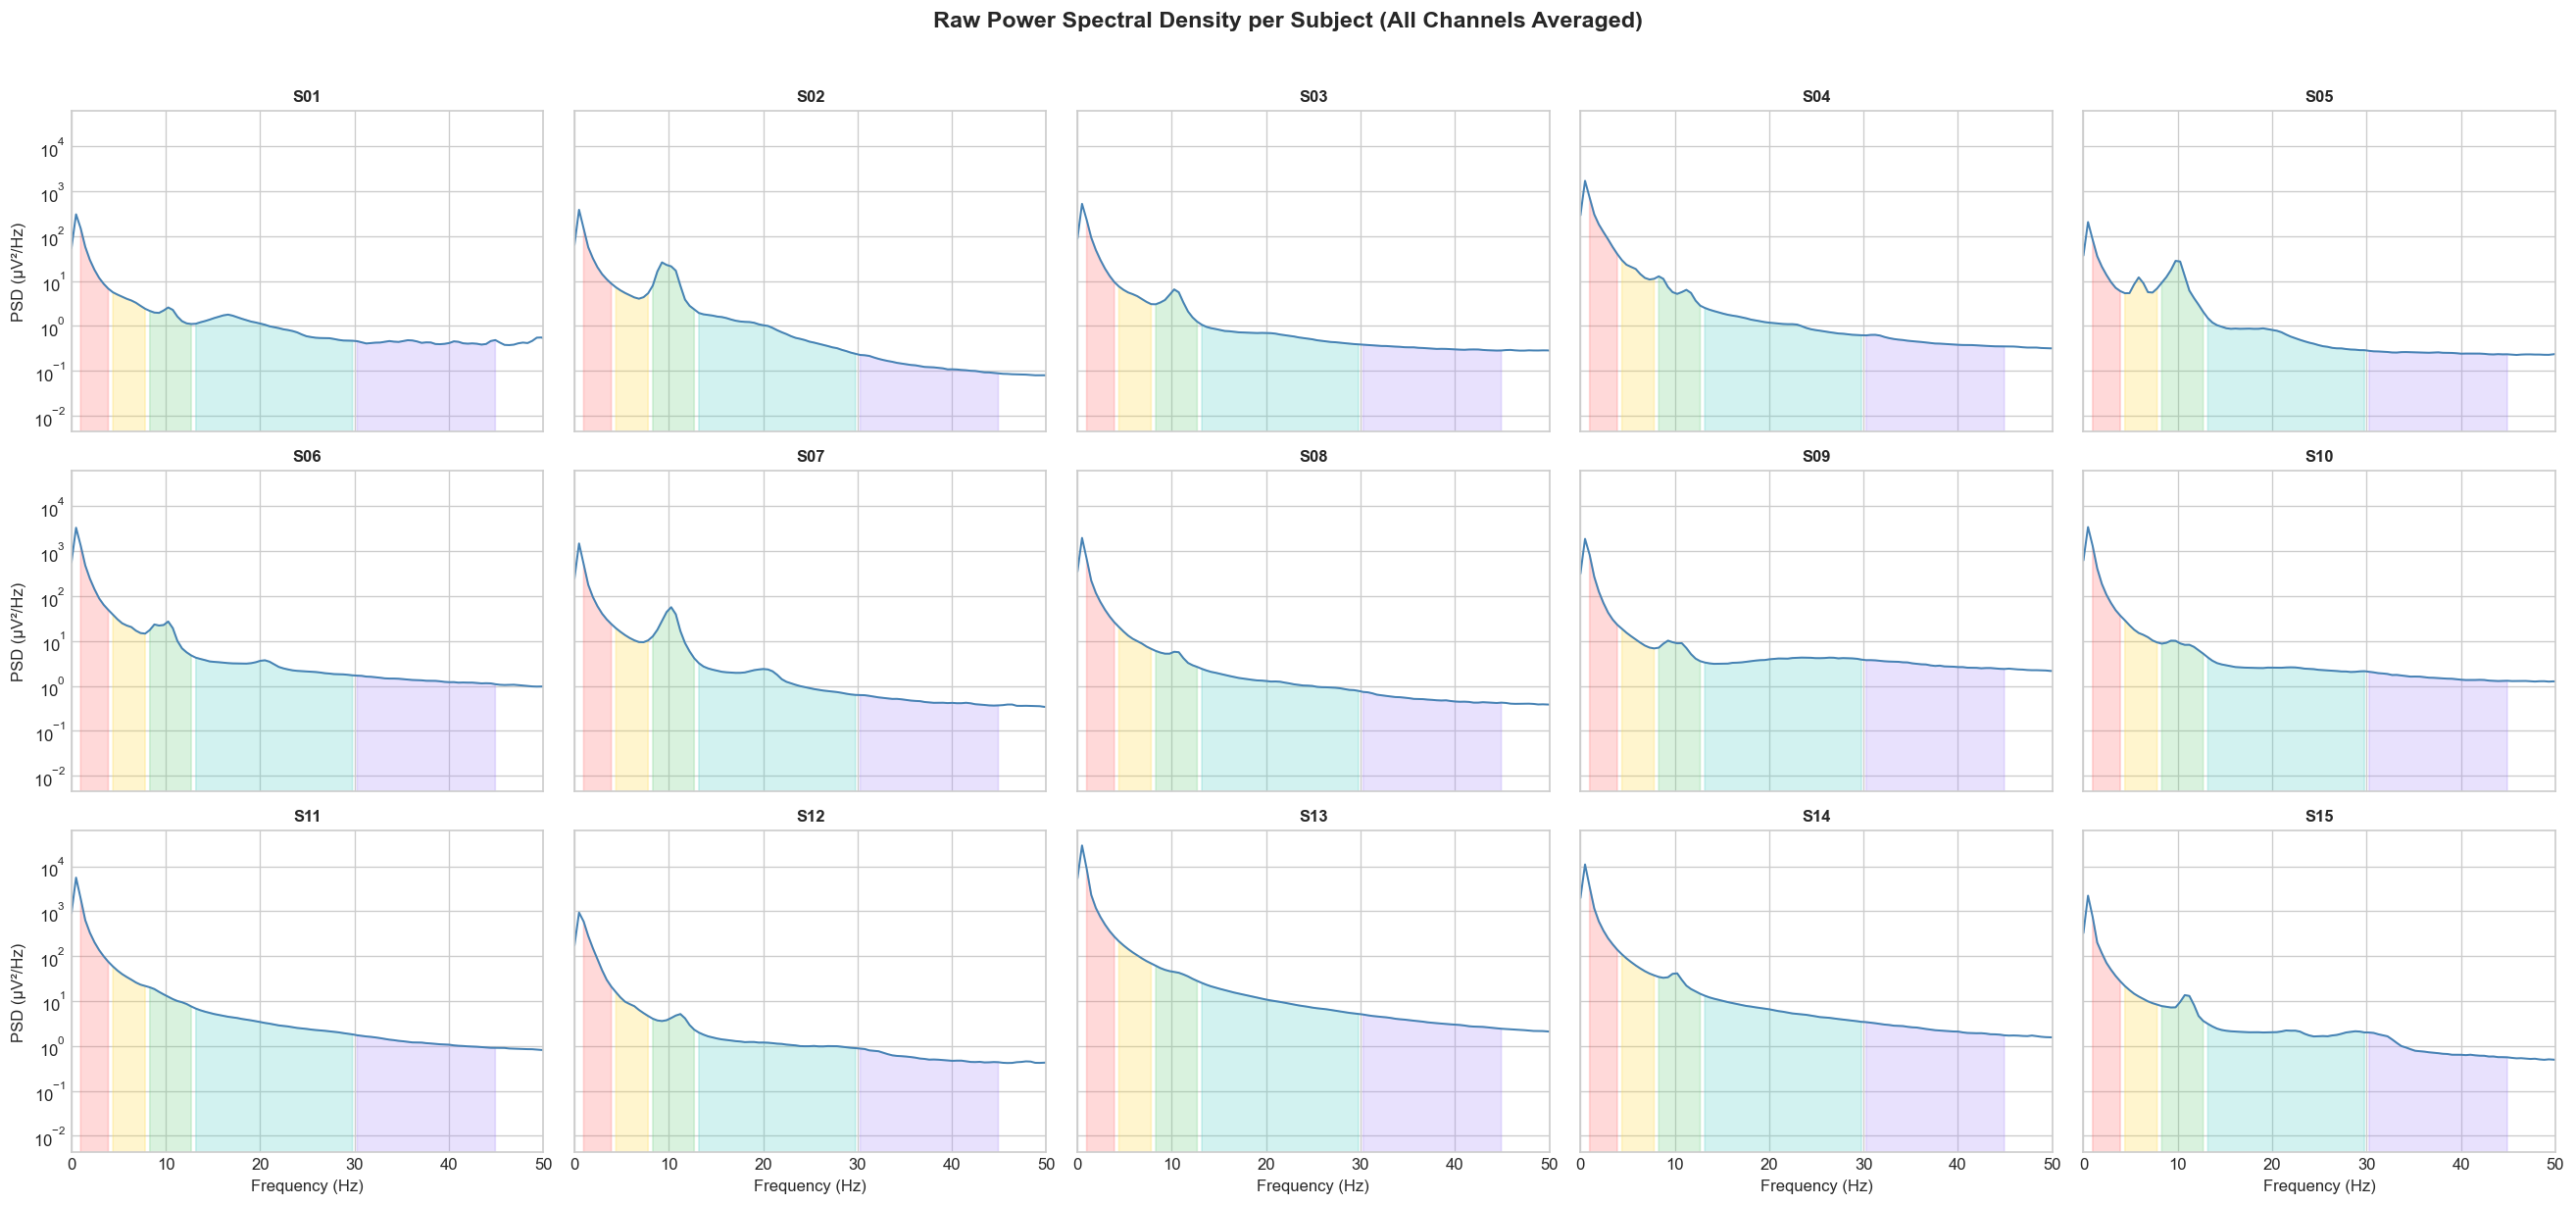


BAND POWER SUMMARY (Mean ± Std across 15 subjects)
  Delta       :     353.21 ±   495.56  ( 89.7% of total)
  Theta       :      23.85 ±    30.49  (  6.1% of total)
  Alpha       :      12.86 ±    10.78  (  3.3% of total)
  Beta        :       2.71 ±     2.72  (  0.7% of total)
  Gamma       :       1.13 ±     1.00  (  0.3% of total)

⚠  If Delta dominates (>50% of total power), the raw data itself
   is heavily low-frequency, making it easy for models to 'cheat'.


In [3]:
# --------------------------------------------------------------------------
# Compute average PSD across all subjects (raw, no ICA yet)
# --------------------------------------------------------------------------

def compute_band_power(psd_values, freqs, band):
    """Compute mean power in a frequency band."""
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.mean(psd_values[:, idx], axis=1).mean()


fig, axes = plt.subplots(3, 5, figsize=(22, 10), sharex=True, sharey=True)
axes = axes.flatten()

all_band_powers = {b: [] for b in BANDS}

for idx, sid in enumerate(sorted(train_data.keys())):
    X_sub = train_data[sid][0]  # (trials, 64, 800)
    
    # Average PSD across all trials and channels using Welch's method
    # Concatenate trials for a longer signal → better frequency resolution
    continuous = X_sub.reshape(X_sub.shape[1], -1)  # (64, trials*800)
    
    freqs, psd = signal.welch(continuous, fs=SFREQ, nperseg=512, noverlap=256)
    
    # psd shape: (64, n_freqs) — average across channels
    mean_psd = psd.mean(axis=0)
    
    # Record band powers for later comparison
    for band_name, band_range in BANDS.items():
        bp = compute_band_power(psd, freqs, band_range)
        all_band_powers[band_name].append(bp)
    
    # Plot individual subject PSD
    ax = axes[idx]
    ax.semilogy(freqs, mean_psd, color='steelblue', linewidth=1.2)
    
    # Shade frequency bands
    colors = {'Delta': '#ff6b6b', 'Theta': '#ffd93d', 'Alpha': '#6bcf7f',
              'Beta': '#4ecdc4', 'Gamma': '#a78bfa'}
    for band_name, (lo, hi) in BANDS.items():
        mask = (freqs >= lo) & (freqs <= hi)
        ax.fill_between(freqs[mask], mean_psd[mask], alpha=0.25, color=colors[band_name])
    
    ax.set_title(f'S{sid}', fontsize=10, fontweight='bold')
    ax.set_xlim(0, 50)
    if idx >= 10:
        ax.set_xlabel('Frequency (Hz)')
    if idx % 5 == 0:
        ax.set_ylabel('PSD (µV²/Hz)')

plt.suptitle('Raw Power Spectral Density per Subject (All Channels Averaged)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------
# Summary: Band power distribution across subjects
# --------------------------------------------------------------------------
print("\n" + "="*65)
print("BAND POWER SUMMARY (Mean ± Std across 15 subjects)")
print("="*65)
total_power = sum(np.mean(v) for v in all_band_powers.values())
for band_name, powers in all_band_powers.items():
    mean_p = np.mean(powers)
    std_p = np.std(powers)
    pct = mean_p / total_power * 100
    print(f"  {band_name:12s}: {mean_p:10.2f} ± {std_p:8.2f}  ({pct:5.1f}% of total)")
print("="*65)
print("\n⚠  If Delta dominates (>50% of total power), the raw data itself")
print("   is heavily low-frequency, making it easy for models to 'cheat'.")


# 4. ICA Decomposition (Per Subject)

We run ICA on each subject independently. Key design choices:
- **Algorithm**: FastICA (fast, well-suited for EEG)
- **Components**: 20 (a conservative number that captures the main sources without overfitting the decomposition)
- **1 Hz high-pass filter** applied before ICA for stability (standard MNE recommendation), but the original data is preserved for back-projection

For each subject, we store:
- The fitted ICA object
- The mixing matrix
- The component time courses
- Per-component spectral profiles

In [5]:
# --------------------------------------------------------------------------
# Run ICA per subject
# --------------------------------------------------------------------------
N_COMPONENTS = 20       # Number of independent components to extract
ICA_METHOD = 'fastica'  # Fast, robust for EEG
RANDOM_STATE = 42

ica_results = {}  # {subject_id: {'ica': ICA, 'raw': Raw, 'raw_filt': Raw}}

for sid in sorted(train_data.keys()):
    print(f"\n{'='*50}")
    print(f"Subject {sid}: Running ICA ({N_COMPONENTS} components, {ICA_METHOD})")
    print(f"{'='*50}")
    
    X_sub = train_data[sid][0]  # (trials, 64, 800)
    
    # 1. Build MNE Raw object from trial data
    raw = build_mne_raw(X_sub, sfreq=SFREQ)
    
    # 2. Apply 1 Hz high-pass filter for ICA stability
    #    This is MNE best practice: ICA is sensitive to slow drifts.
    #    We keep the original raw for back-projection later.
    raw_filt = raw.copy().filter(l_freq=1.0, h_freq=None, verbose=False)
    
    # 3. Fit ICA
    ica = ICA(
        n_components=N_COMPONENTS,
        method=ICA_METHOD,
        random_state=RANDOM_STATE,
        max_iter=500,
    )
    ica.fit(raw_filt, verbose=False)
    
    # 4. Store results
    ica_results[sid] = {
        'ica': ica,
        'raw': raw,
        'raw_filt': raw_filt,
    }
    
    # 5. Quick summary
    explained_var = ica.get_explained_variance_ratio(raw_filt)
    total_var = sum(explained_var.values()) if isinstance(explained_var, dict) else explained_var
    print(f"  Fit complete. Explained variance ratio: {total_var}")

print(f"\n✓ ICA decomposition complete for all {len(ica_results)} subjects.")


Subject 01: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.927427380902958

Subject 02: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.946266415900371

Subject 03: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.9660140672382813

Subject 04: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.9884672679545286

Subject 05: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.9380241895493233

Subject 06: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.9808884296327933

Subject 07: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.9619814242135831

Subject 08: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.9584941265957729

Subject 09: Running ICA (20 components, fastica)
  Fit complete. Explained variance ratio: 0.9690605848632393

Su

# 5. Component Spectral Characterization

For each subject we compute the **power spectrum of every IC** and identify which
components are delta-dominant. A component is flagged as "delta-dominant" if >50%
of its total power (0.5–45 Hz) lies in the delta band (0.5–4 Hz).

This is the core diagnostic: if many ICs are delta-dominant across subjects, the
signal space is saturated with low-frequency activity that the model can latch onto.

In [6]:
# --------------------------------------------------------------------------
# Compute spectral profile of each IC for every subject
# --------------------------------------------------------------------------

DELTA_THRESHOLD = 0.50  # A component is "delta-dominant" if >50% power is in delta

# Storage: per-subject IC spectral analysis
ic_spectral_data = {}

for sid in sorted(ica_results.keys()):
    ica = ica_results[sid]['ica']
    raw_filt = ica_results[sid]['raw_filt']
    
    # Get IC source time courses: (n_components, n_times)
    sources = ica.get_sources(raw_filt)
    source_data = sources.get_data()  # (20, n_times)
    
    ic_info = []
    
    for ic_idx in range(N_COMPONENTS):
        ic_signal = source_data[ic_idx]
        
        # Welch PSD of this component
        freqs_ic, psd_ic = signal.welch(ic_signal, fs=SFREQ, nperseg=512, noverlap=256)
        
        # Compute power in each band
        band_powers = {}
        for band_name, (lo, hi) in BANDS.items():
            mask = (freqs_ic >= lo) & (freqs_ic <= hi)
            band_powers[band_name] = np.mean(psd_ic[mask])
        
        total_pow = sum(band_powers.values())
        band_pct = {b: p / total_pow * 100 for b, p in band_powers.items()}
        
        is_delta_dominant = band_pct['Delta'] > (DELTA_THRESHOLD * 100)
        
        ic_info.append({
            'ic_idx': ic_idx,
            'freqs': freqs_ic,
            'psd': psd_ic,
            'band_powers': band_powers,
            'band_pct': band_pct,
            'delta_dominant': is_delta_dominant,
            'delta_pct': band_pct['Delta'],
        })
    
    ic_spectral_data[sid] = ic_info
    
    # Quick count
    n_delta = sum(1 for ic in ic_info if ic['delta_dominant'])
    print(f"Subject {sid}: {n_delta}/{N_COMPONENTS} ICs are delta-dominant (>{DELTA_THRESHOLD*100:.0f}% delta power)")

# --------------------------------------------------------------------------
# Summary table across all subjects
# --------------------------------------------------------------------------
print("\n" + "="*60)
print("DELTA-DOMINANT IC COUNT PER SUBJECT")
print("="*60)
delta_counts = []
for sid in sorted(ic_spectral_data.keys()):
    n_delta = sum(1 for ic in ic_spectral_data[sid] if ic['delta_dominant'])
    delta_counts.append(n_delta)
    bar = '█' * n_delta + '░' * (N_COMPONENTS - n_delta)
    print(f"  S{sid}: [{bar}] {n_delta}/{N_COMPONENTS}")

print(f"\n  Mean: {np.mean(delta_counts):.1f} ± {np.std(delta_counts):.1f} delta-dominant ICs per subject")
print(f"  This means ~{np.mean(delta_counts)/N_COMPONENTS*100:.0f}% of independent sources are delta-heavy.")

Subject 01: 17/20 ICs are delta-dominant (>50% delta power)
Subject 02: 17/20 ICs are delta-dominant (>50% delta power)
Subject 03: 18/20 ICs are delta-dominant (>50% delta power)
Subject 04: 17/20 ICs are delta-dominant (>50% delta power)
Subject 05: 13/20 ICs are delta-dominant (>50% delta power)
Subject 06: 16/20 ICs are delta-dominant (>50% delta power)
Subject 07: 15/20 ICs are delta-dominant (>50% delta power)
Subject 08: 20/20 ICs are delta-dominant (>50% delta power)
Subject 09: 13/20 ICs are delta-dominant (>50% delta power)
Subject 10: 19/20 ICs are delta-dominant (>50% delta power)
Subject 11: 19/20 ICs are delta-dominant (>50% delta power)
Subject 12: 14/20 ICs are delta-dominant (>50% delta power)
Subject 13: 20/20 ICs are delta-dominant (>50% delta power)
Subject 14: 17/20 ICs are delta-dominant (>50% delta power)
Subject 15: 18/20 ICs are delta-dominant (>50% delta power)

DELTA-DOMINANT IC COUNT PER SUBJECT
  S01: [█████████████████░░░] 17/20
  S02: [█████████████████░░

# 6. IC Topographic Maps & Spectral Profiles (Detailed View)

For **3 representative subjects** (S01, S08, S15), we visualize:
- **Top row**: Scalp topography of each IC (mixing weights projected onto electrodes)
- **Bottom row**: PSD of each IC, color-coded by dominant band

Delta-dominant ICs with **frontal** topography strongly suggest **ocular artifacts**
(eye blinks/movements). Delta-dominant ICs with **diffuse** topography may indicate
**slow drifts** or **movement artifacts**.


Subject 01: IC Topographic Maps


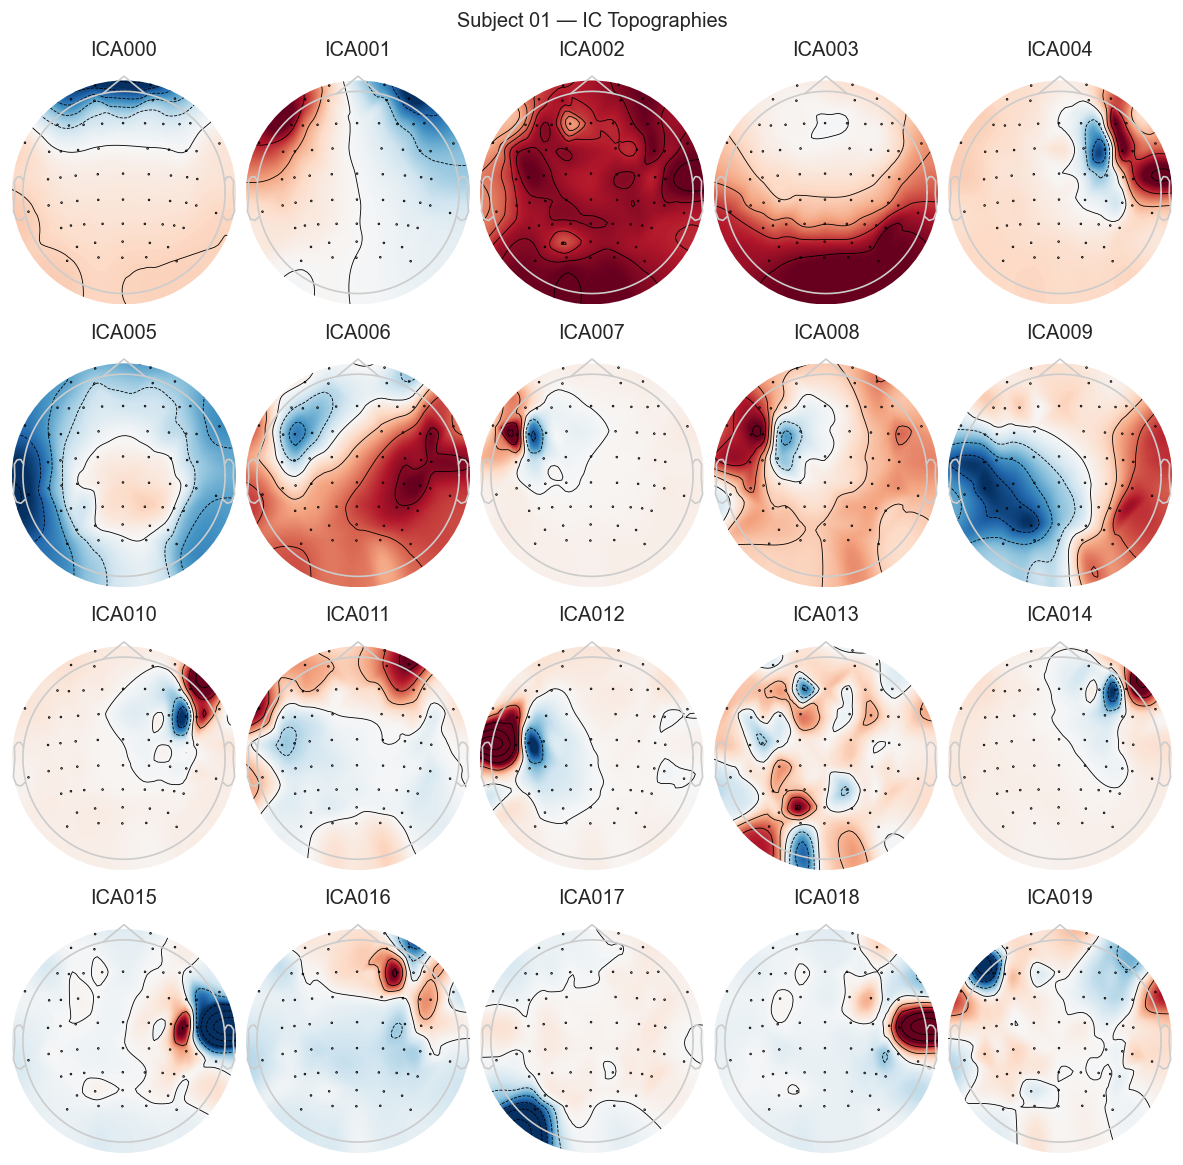

/tmp/ipykernel_2916927/3091001111.py:77: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


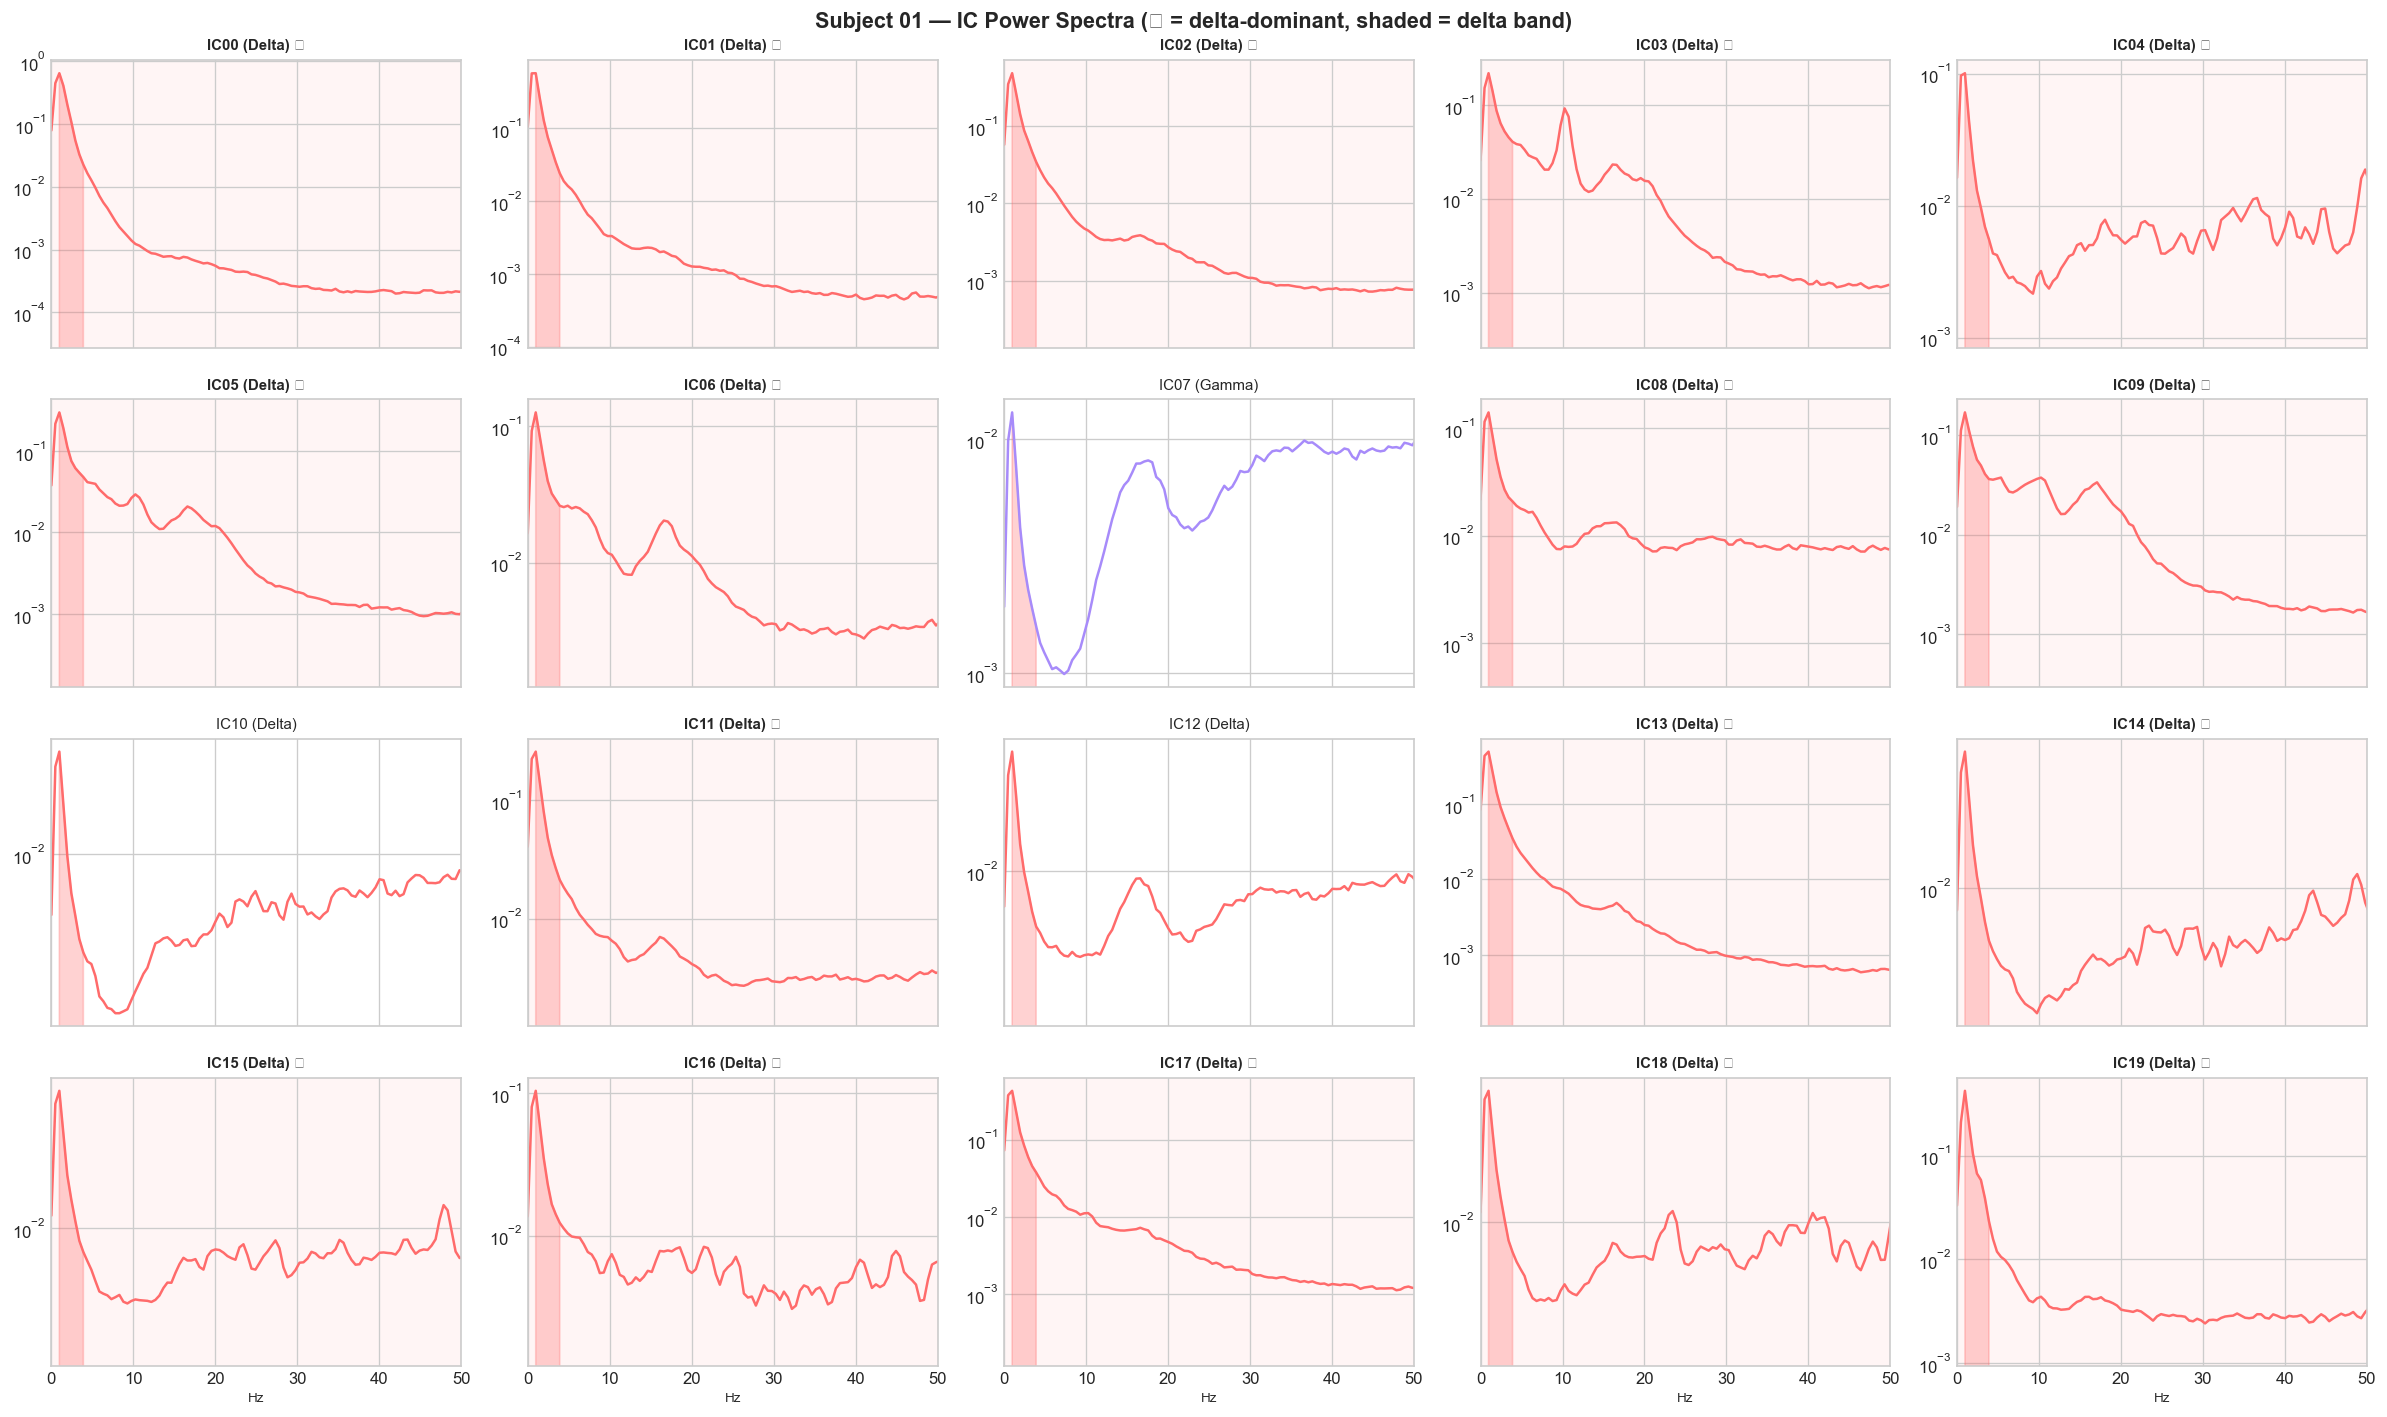


Subject 08: IC Topographic Maps


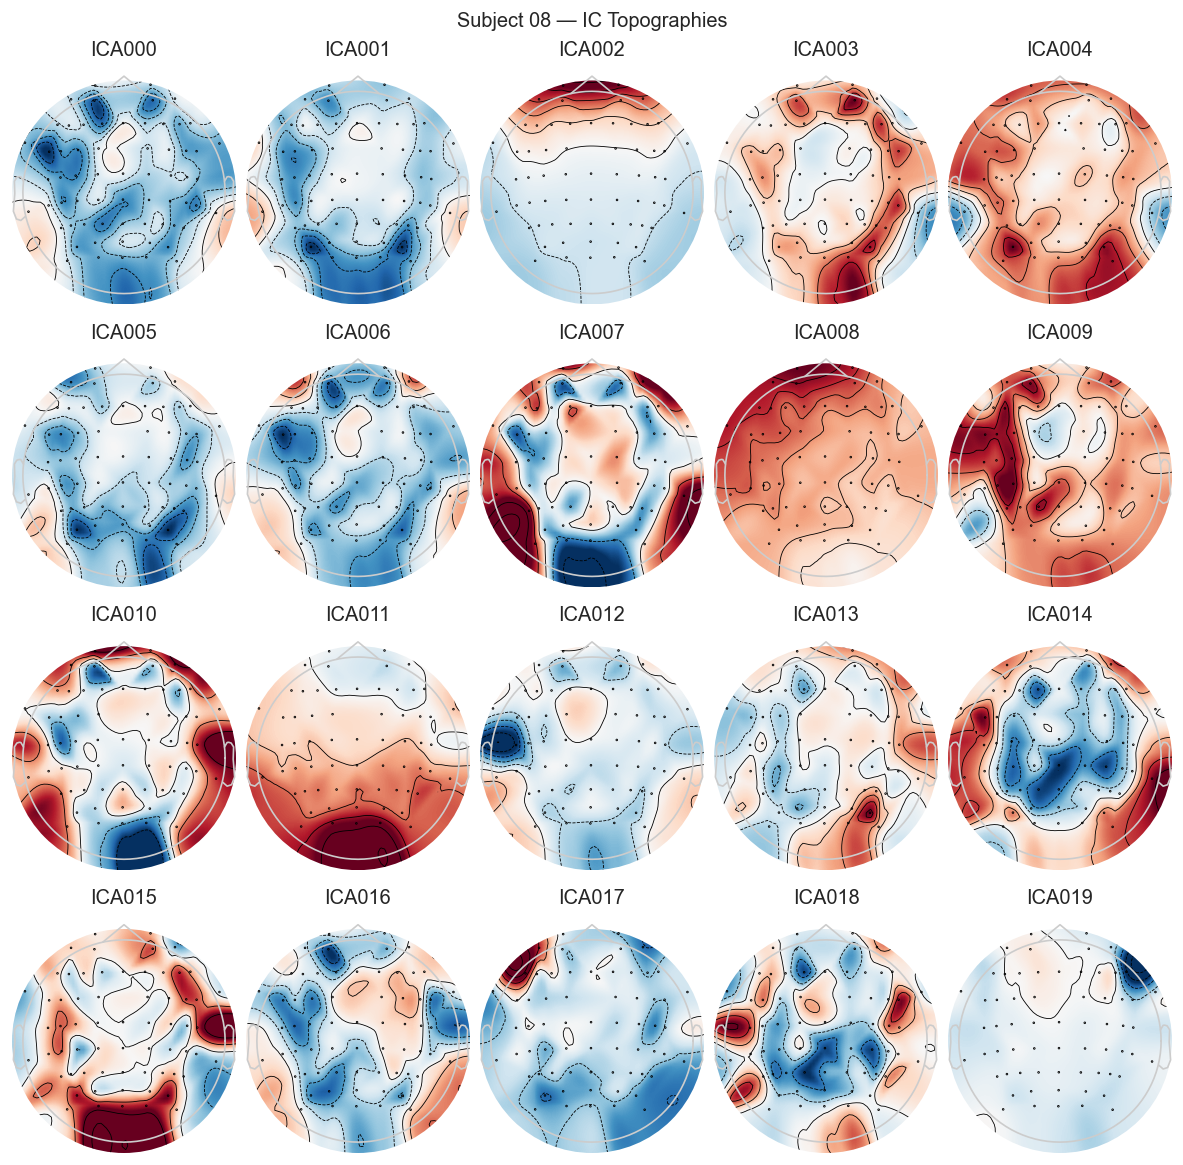

/tmp/ipykernel_2916927/3091001111.py:77: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


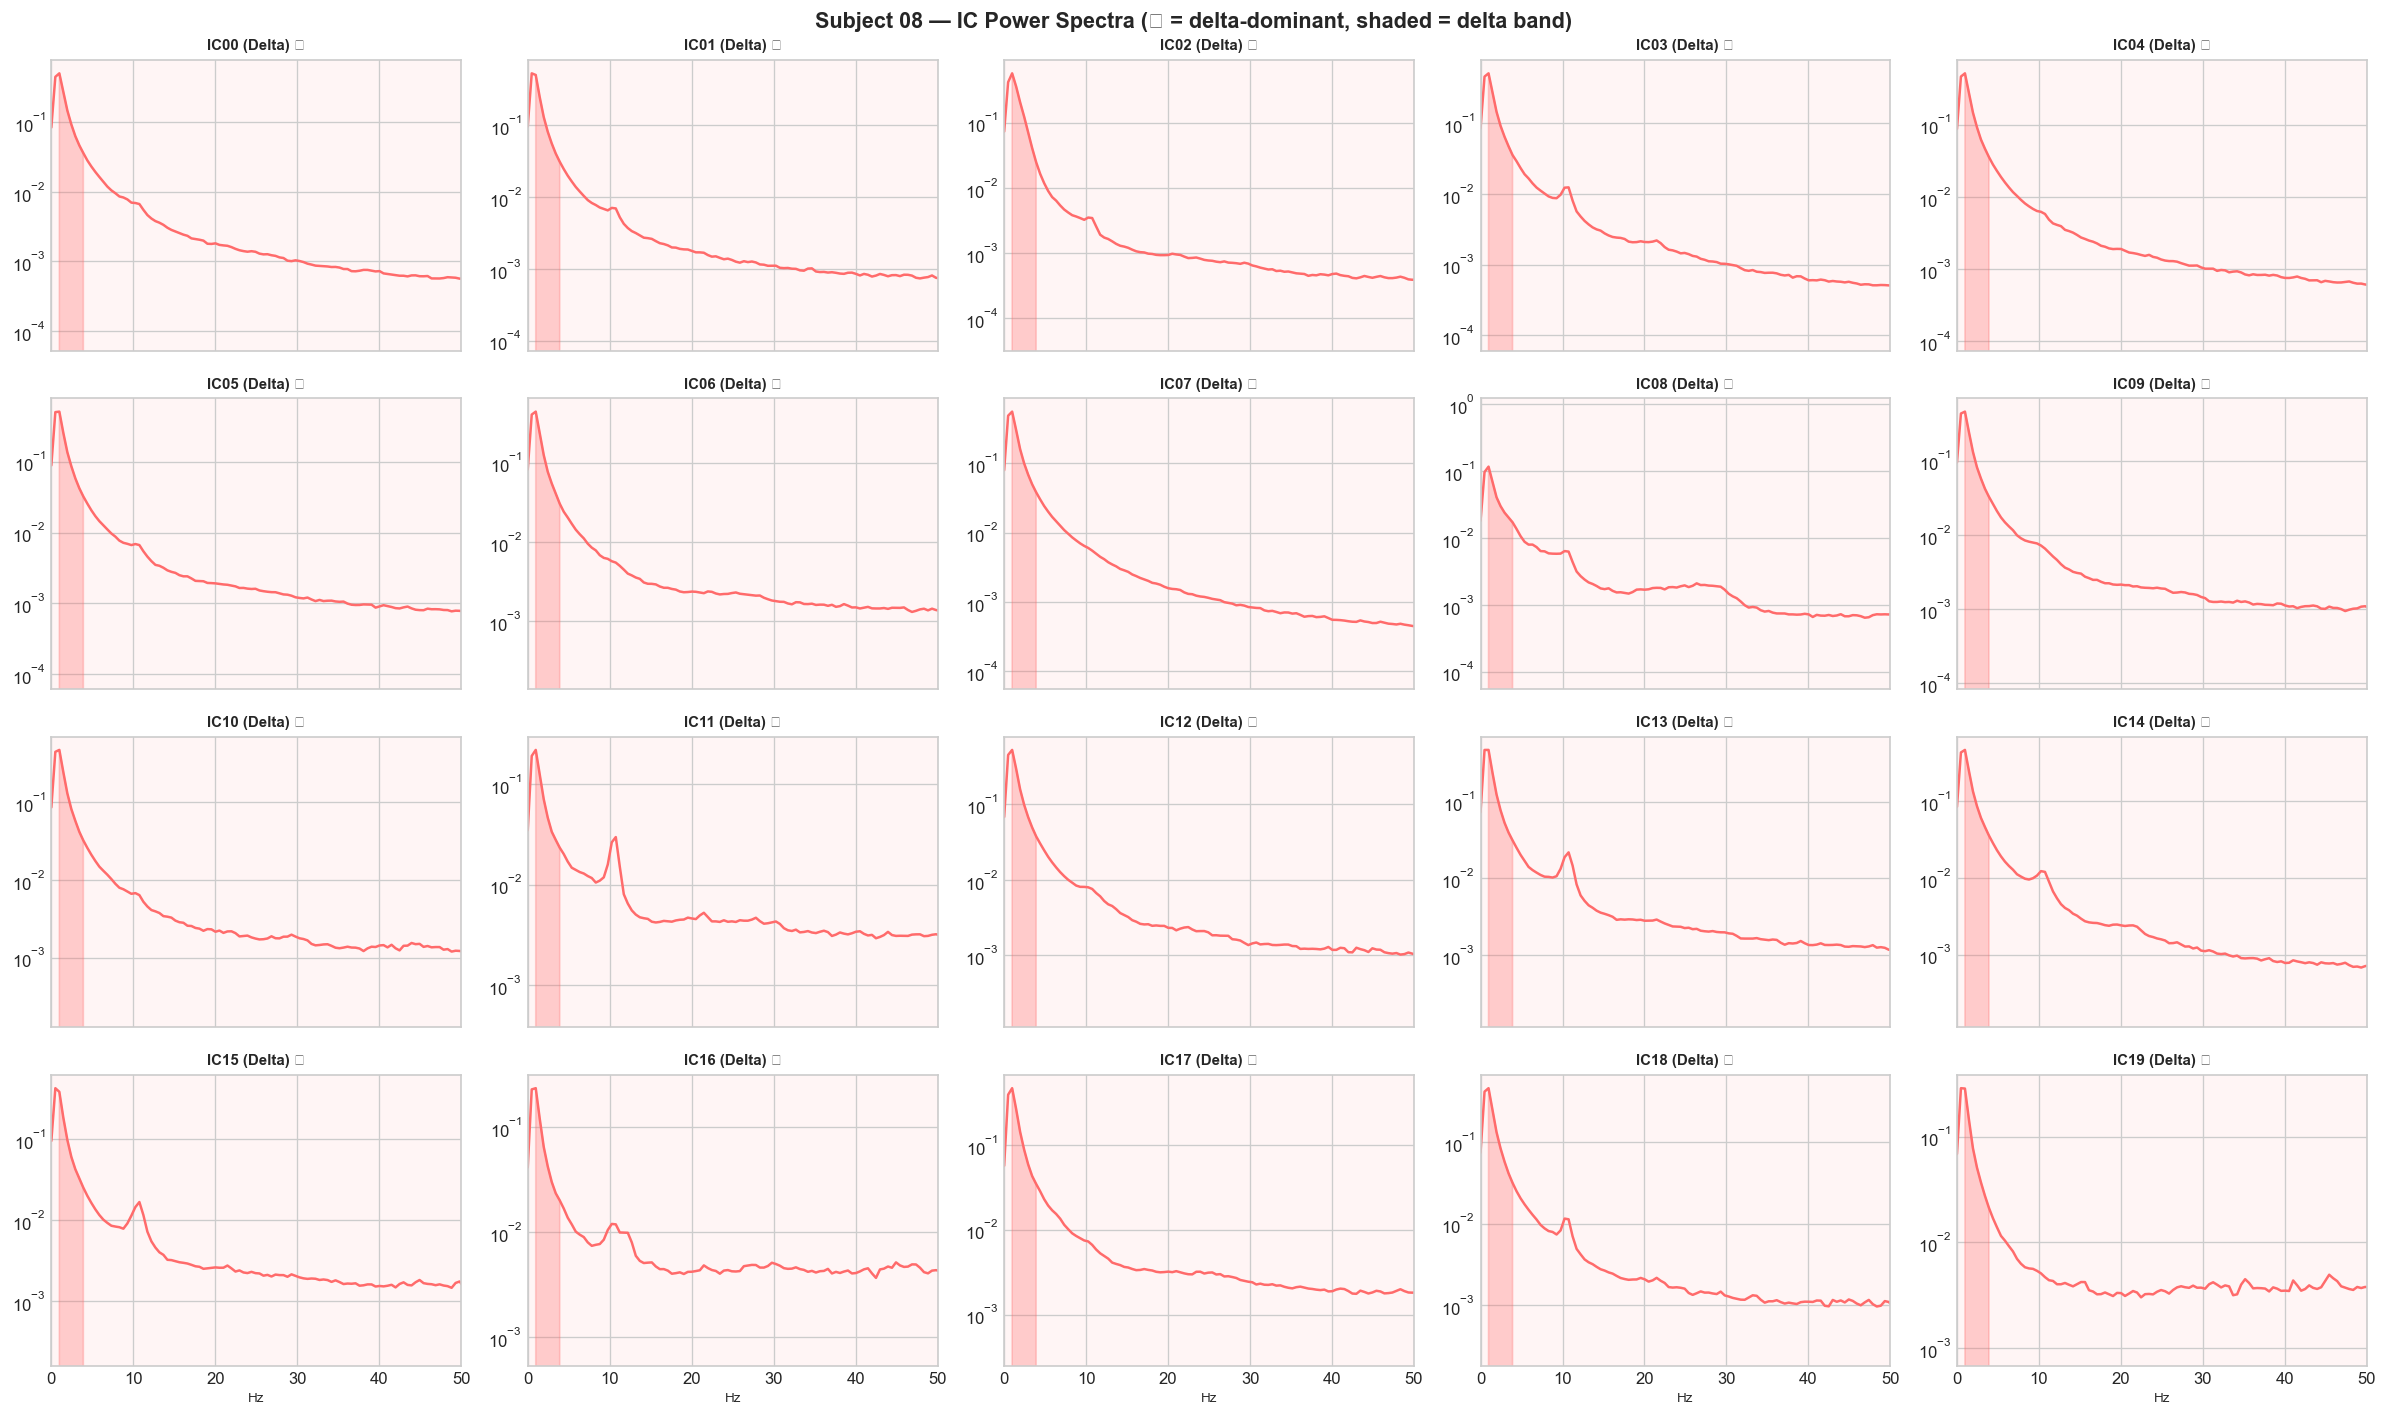


Subject 15: IC Topographic Maps


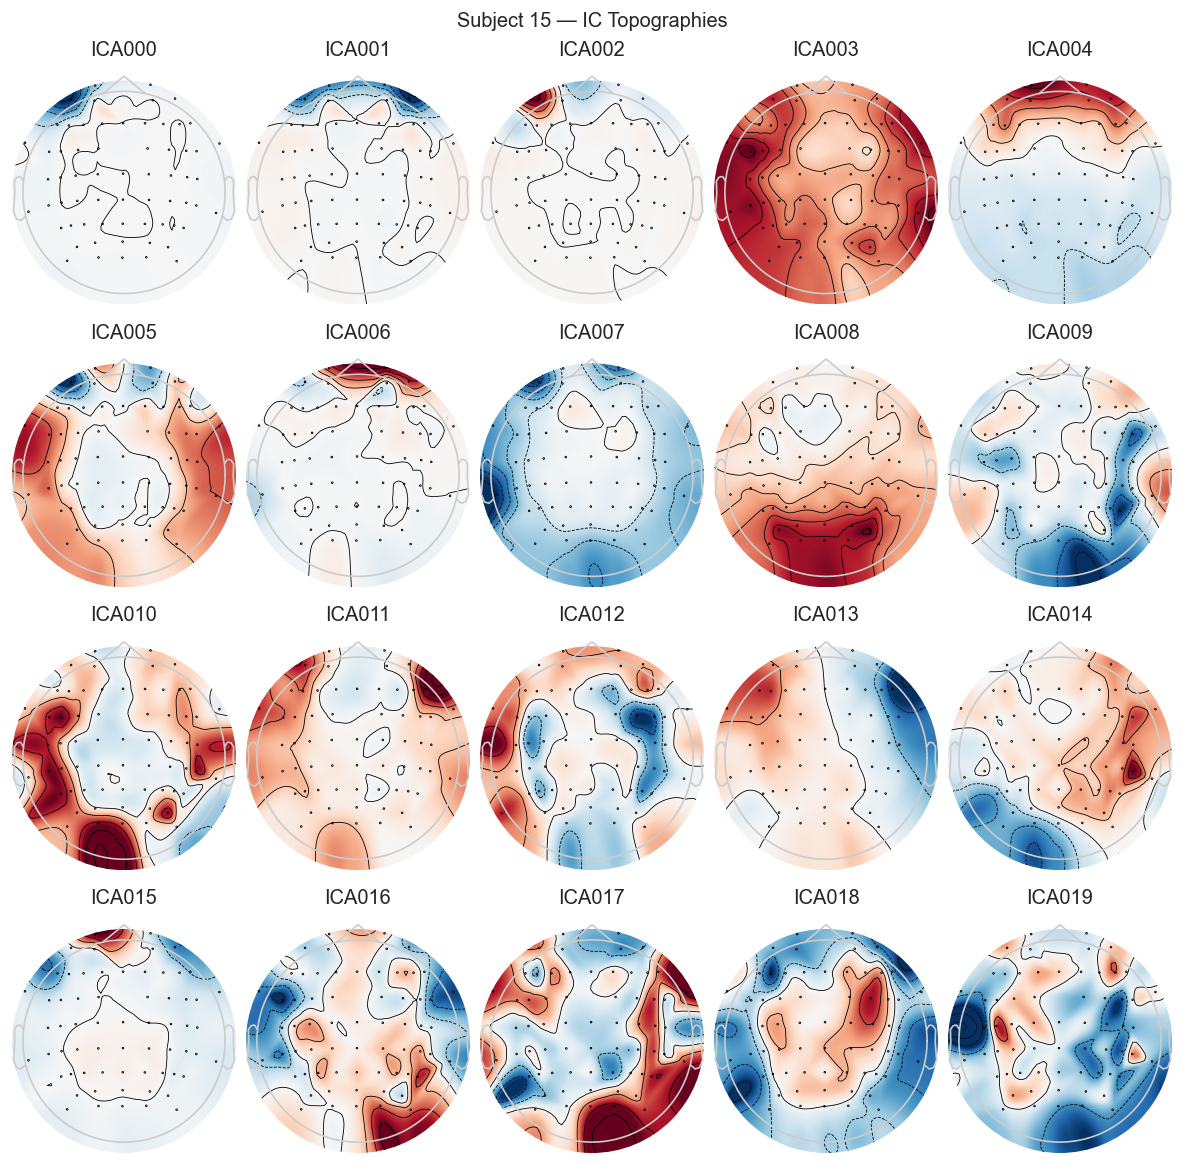

/tmp/ipykernel_2916927/3091001111.py:77: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


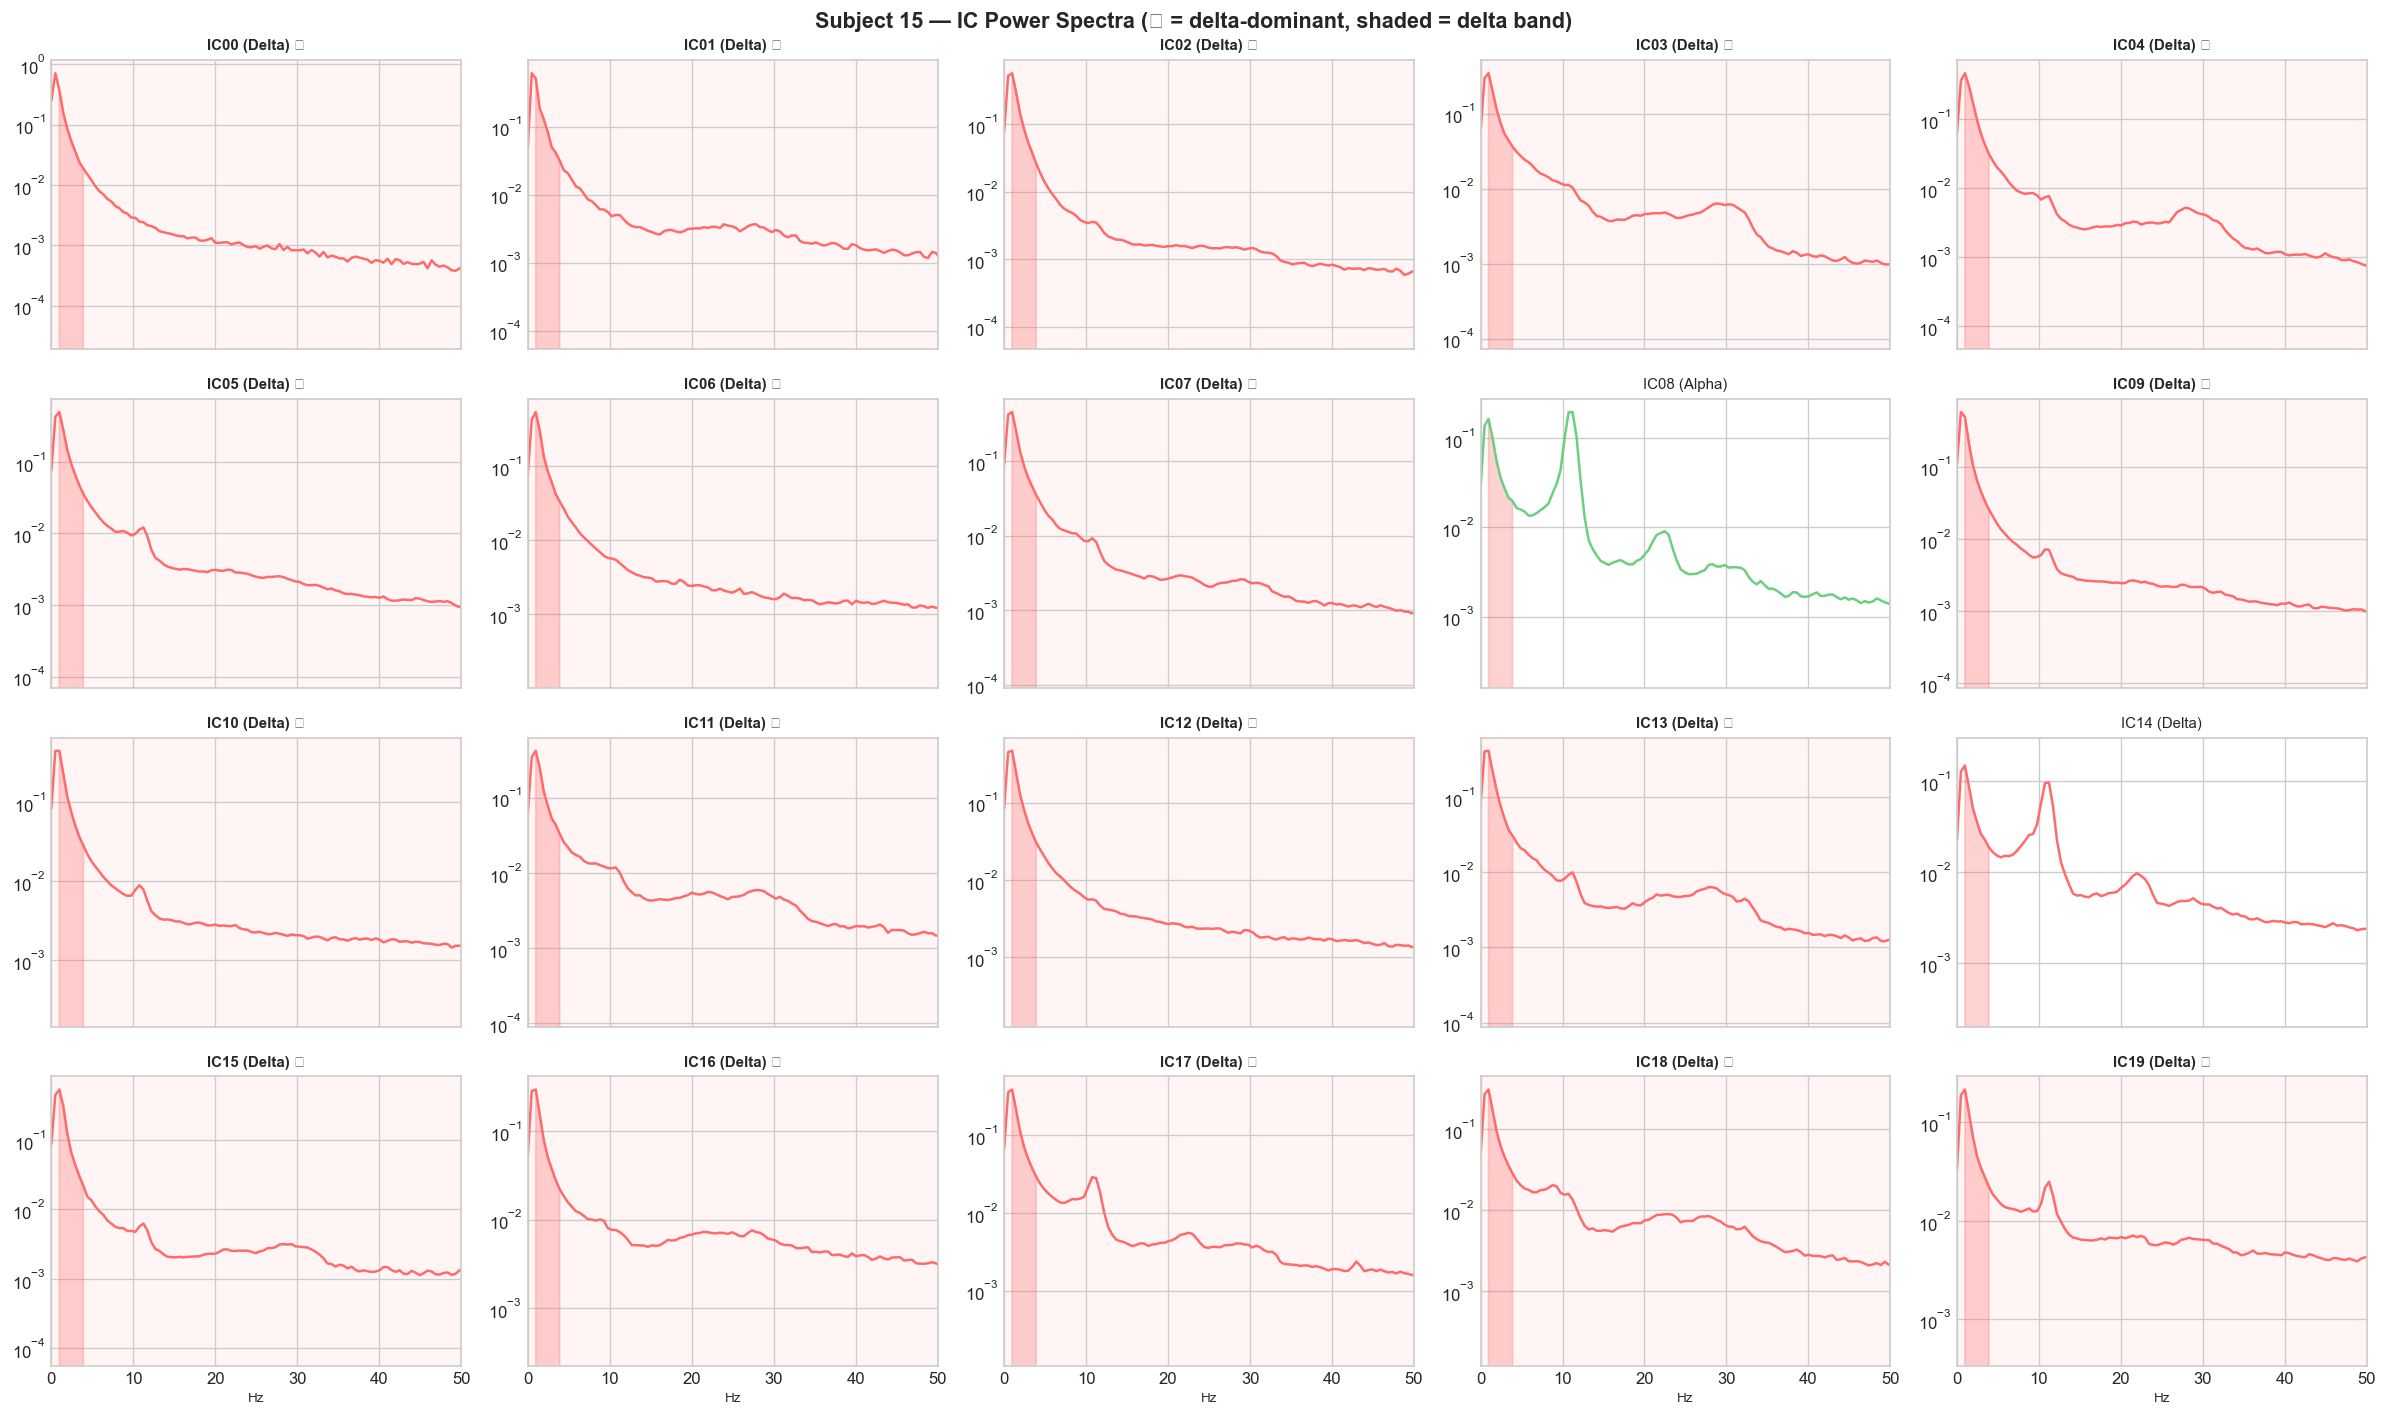

In [7]:
# --------------------------------------------------------------------------
# Detailed IC visualization for representative subjects
# --------------------------------------------------------------------------

REPRESENTATIVE_SUBJECTS = ['01', '08', '15']  # low, mid, high subject indices

for sid in REPRESENTATIVE_SUBJECTS:
    if sid not in ica_results:
        print(f"Subject {sid} not found, skipping.")
        continue
    
    ica = ica_results[sid]['ica']
    raw_filt = ica_results[sid]['raw_filt']
    ic_info_list = ic_spectral_data[sid]
    
    # --- A) Topographic maps of all ICs ---
    print(f"\n{'='*60}")
    print(f"Subject {sid}: IC Topographic Maps")
    print(f"{'='*60}")
    
    fig = ica.plot_components(
        picks=range(N_COMPONENTS),
        ch_type='eeg',
        show=False,
        title=f'Subject {sid} — IC Topographies',
    )
    # Mark delta-dominant ICs in the title
    if isinstance(fig, list):
        for f in fig:
            plt.figure(f.number)
            plt.suptitle(f'Subject {sid} — IC Topographies (red border = delta-dominant)',
                         fontsize=11, fontweight='bold')
    plt.show()
    
    # --- B) Spectral profiles of all ICs ---
    n_cols = 5
    n_rows = (N_COMPONENTS + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows), sharex=True)
    axes = axes.flatten()
    
    for ic_idx in range(N_COMPONENTS):
        ax = axes[ic_idx]
        ic = ic_info_list[ic_idx]
        
        # Color based on dominant band
        dominant_band = max(ic['band_pct'], key=ic['band_pct'].get)
        band_colors = {
            'Delta': '#ff6b6b', 'Theta': '#ffd93d', 'Alpha': '#6bcf7f',
            'Beta': '#4ecdc4', 'Gamma': '#a78bfa'
        }
        line_color = band_colors.get(dominant_band, 'gray')
        
        ax.semilogy(ic['freqs'], ic['psd'], color=line_color, linewidth=1.5)
        
        # Highlight delta region
        delta_mask = (ic['freqs'] >= 0.5) & (ic['freqs'] <= 4)
        ax.fill_between(ic['freqs'][delta_mask], ic['psd'][delta_mask],
                        alpha=0.3, color='#ff6b6b')
        
        title = f"IC{ic_idx:02d} ({dominant_band})"
        if ic['delta_dominant']:
            title += " ★"
            ax.set_facecolor('#fff5f5')
        
        ax.set_title(title, fontsize=9, fontweight='bold' if ic['delta_dominant'] else 'normal')
        ax.set_xlim(0, 50)
        
        if ic_idx >= (n_rows - 1) * n_cols:
            ax.set_xlabel('Hz', fontsize=8)
    
    # Hide unused axes
    for j in range(N_COMPONENTS, len(axes)):
        axes[j].set_visible(False)
    
    fig.suptitle(f'Subject {sid} — IC Power Spectra (★ = delta-dominant, shaded = delta band)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 7. Delta-Dominant IC Topography Classification

For each delta-dominant IC, we classify its **spatial pattern** into:
- **Frontal** (likely ocular artifact: blinks, saccades)
- **Temporal-peripheral** (likely muscle artifact)
- **Diffuse/Global** (likely slow drift or reference artifact)
- **Focal-posterior** (possibly neural: slow cortical potentials)

This is done by examining where the IC mixing weights are strongest relative to
the FAST zone definitions.

In [8]:
# --------------------------------------------------------------------------
# Classify delta-dominant ICs by their spatial distribution
# --------------------------------------------------------------------------

def classify_ic_topography(mixing_weights, electrodes, zones):
    """Classify an IC's spatial pattern based on zone-wise weight concentration.
    
    Args:
        mixing_weights: (n_channels,) — one column of the mixing matrix
        electrodes: list of channel names (ordered)
        zones: dict {zone_name: [channel_names]}
        
    Returns:
        str: classification label
    """
    abs_weights = np.abs(mixing_weights)
    total_energy = abs_weights.sum()
    
    # Compute energy fraction per zone
    zone_energy = {}
    for zone_name, zone_chs in zones.items():
        ch_indices = [electrodes.index(ch) for ch in zone_chs if ch in electrodes]
        zone_energy[zone_name] = abs_weights[ch_indices].sum() / total_energy
    
    # Classification heuristics
    frontal_energy = zone_energy.get('Pre-frontal', 0) + zone_energy.get('Frontal', 0)
    temporal_energy = zone_energy.get('Temporal', 0)
    posterior_energy = zone_energy.get('Parietal', 0) + zone_energy.get('Occipital', 0)
    
    # Check if energy is broadly distributed (diffuse)
    max_zone_energy = max(zone_energy.values())
    
    if frontal_energy > 0.40:
        return 'Frontal (likely ocular)'
    elif temporal_energy > 0.35:
        return 'Temporal (likely muscle)'
    elif posterior_energy > 0.40:
        return 'Posterior (possibly neural)'
    elif max_zone_energy < 0.25:
        return 'Diffuse (likely drift/ref)'
    else:
        dominant_zone = max(zone_energy, key=zone_energy.get)
        return f'Focal-{dominant_zone}'


# --------------------------------------------------------------------------
# Classify all delta-dominant ICs across all subjects
# --------------------------------------------------------------------------

classification_summary = {
    'Frontal (likely ocular)': 0,
    'Temporal (likely muscle)': 0,
    'Posterior (possibly neural)': 0,
    'Diffuse (likely drift/ref)': 0,
}

all_classifications = {}

print(f"{'Subject':<10} {'IC':<6} {'Delta%':<10} {'Classification':<30}")
print("-" * 60)

for sid in sorted(ica_results.keys()):
    ica = ica_results[sid]['ica']
    ic_info_list = ic_spectral_data[sid]
    
    # Mixing matrix: (n_channels, n_components)
    mixing = ica.get_components()
    
    subject_classifications = []
    
    for ic in ic_info_list:
        if ic['delta_dominant']:
            ic_idx = ic['ic_idx']
            weights = mixing[:, ic_idx]
            
            label = classify_ic_topography(weights, ELECTRODES, ZONES)
            subject_classifications.append((ic_idx, label, ic['delta_pct']))
            
            # Count in summary
            matched = False
            for key in classification_summary:
                if key in label:
                    classification_summary[key] += 1
                    matched = True
                    break
            if not matched:
                classification_summary.setdefault(label, 0)
                classification_summary[label] = classification_summary.get(label, 0) + 1
            
            print(f"  S{sid:<7} IC{ic_idx:02d}   {ic['delta_pct']:5.1f}%     {label}")
    
    all_classifications[sid] = subject_classifications

# --------------------------------------------------------------------------
# Summary
# --------------------------------------------------------------------------
print("\n" + "="*60)
print("CLASSIFICATION SUMMARY (All Subjects Combined)")
print("="*60)
total_delta_ics = sum(classification_summary.values())
for label, count in sorted(classification_summary.items(), key=lambda x: -x[1]):
    pct = count / total_delta_ics * 100 if total_delta_ics > 0 else 0
    bar = '█' * int(pct / 2)
    print(f"  {label:<30}: {count:3d} ({pct:5.1f}%) {bar}")

print(f"\n  Total delta-dominant ICs: {total_delta_ics}")
print("\n🔑 KEY INSIGHT:")
print("  If 'Frontal (likely ocular)' dominates → the model is exploiting blink artifacts.")
print("  If 'Diffuse' dominates → slow drifts are the main delta source.")
print("  If 'Posterior' is significant → some delta may be genuinely neural.")

Subject    IC     Delta%     Classification                
------------------------------------------------------------
  S01      IC00    95.5%     Frontal (likely ocular)
  S01      IC01    90.8%     Frontal (likely ocular)
  S01      IC02    87.5%     Diffuse (likely drift/ref)
  S01      IC03    53.5%     Posterior (possibly neural)
  S01      IC04    60.2%     Diffuse (likely drift/ref)
  S01      IC05    65.3%     Focal-Temporal
  S01      IC06    53.8%     Focal-Parietal
  S01      IC08    56.8%     Focal-Temporal
  S01      IC09    50.2%     Posterior (possibly neural)
  S01      IC11    77.3%     Frontal (likely ocular)
  S01      IC13    86.1%     Focal-Parietal
  S01      IC14    55.5%     Frontal (likely ocular)
  S01      IC15    56.7%     Temporal (likely muscle)
  S01      IC16    59.7%     Diffuse (likely drift/ref)
  S01      IC17    80.3%     Posterior (possibly neural)
  S01      IC18    53.2%     Focal-Temporal
  S01      IC19    87.1%     Frontal (likely ocular)
 

# 8. Cross-Subject IC Consistency Analysis

A critical question: are the delta-dominant components **consistent across subjects**,
or are they **subject-specific**?

- If consistent → the delta sources are systematic (artifact or shared neural pattern)
- If subject-specific → the model may be learning individual baselines, causing poor generalization

We compare the spatial patterns of delta-dominant ICs across subjects using
correlation of their mixing weight vectors.

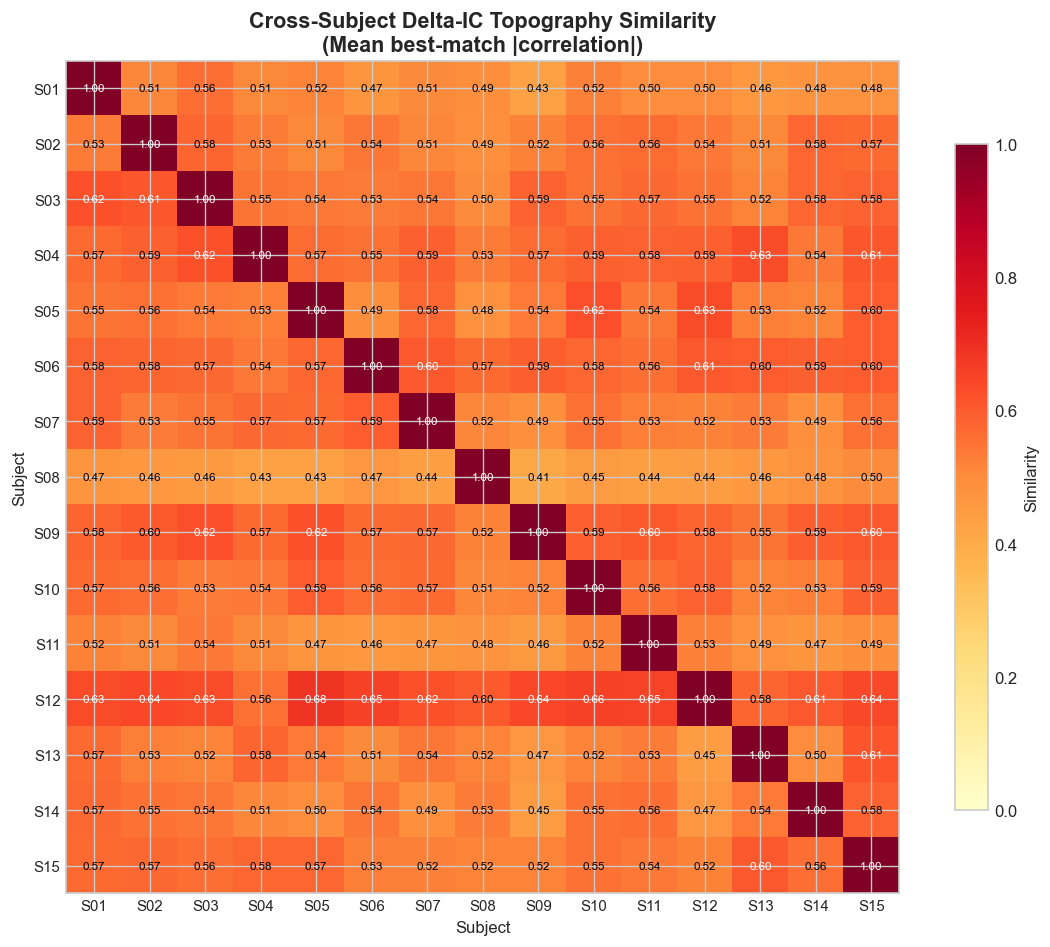


Cross-subject delta-IC similarity: 0.542 ± 0.048
Range: [0.408, 0.638]

⚡ MODERATE similarity → Some delta ICs share spatial patterns.
  A mix of shared artifacts and subject-specific sources is likely.


In [9]:
# --------------------------------------------------------------------------
# Cross-subject similarity of delta-dominant IC topographies
# --------------------------------------------------------------------------

def get_delta_ic_topographies(sid):
    """Return mixing weight vectors for all delta-dominant ICs of a subject."""
    ica = ica_results[sid]['ica']
    mixing = ica.get_components()  # (n_channels, n_components)
    ic_info_list = ic_spectral_data[sid]
    
    topos = []
    for ic in ic_info_list:
        if ic['delta_dominant']:
            topos.append(mixing[:, ic['ic_idx']])
    return topos

# For each pair of subjects, compute max correlation between their delta ICs
subject_ids = sorted(ica_results.keys())
n_subs = len(subject_ids)
cross_sub_sim = np.zeros((n_subs, n_subs))

for i, sid_a in enumerate(subject_ids):
    topos_a = get_delta_ic_topographies(sid_a)
    for j, sid_b in enumerate(subject_ids):
        if i == j:
            cross_sub_sim[i, j] = 1.0
            continue
        topos_b = get_delta_ic_topographies(sid_b)
        
        if len(topos_a) == 0 or len(topos_b) == 0:
            cross_sub_sim[i, j] = 0.0
            continue
        
        # Best-match correlation: for each IC in A, find max |corr| with any IC in B
        max_corrs = []
        for ta in topos_a:
            corrs = [np.abs(np.corrcoef(ta, tb)[0, 1]) for tb in topos_b]
            max_corrs.append(max(corrs))
        cross_sub_sim[i, j] = np.mean(max_corrs)

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cross_sub_sim, cmap='YlOrRd', vmin=0, vmax=1, aspect='equal')

ax.set_xticks(range(n_subs))
ax.set_xticklabels([f'S{s}' for s in subject_ids], fontsize=9)
ax.set_yticks(range(n_subs))
ax.set_yticklabels([f'S{s}' for s in subject_ids], fontsize=9)
ax.set_xlabel('Subject')
ax.set_ylabel('Subject')
ax.set_title('Cross-Subject Delta-IC Topography Similarity\n(Mean best-match |correlation|)',
             fontsize=13, fontweight='bold')

# Annotate
for i in range(n_subs):
    for j in range(n_subs):
        ax.text(j, i, f'{cross_sub_sim[i,j]:.2f}', ha='center', va='center',
                fontsize=7, color='white' if cross_sub_sim[i,j] > 0.6 else 'black')

plt.colorbar(im, ax=ax, shrink=0.8, label='Similarity')
plt.tight_layout()
plt.show()

# Summary statistics
off_diag = cross_sub_sim[np.triu_indices(n_subs, k=1)]
print(f"\nCross-subject delta-IC similarity: {off_diag.mean():.3f} ± {off_diag.std():.3f}")
print(f"Range: [{off_diag.min():.3f}, {off_diag.max():.3f}]")
print()
if off_diag.mean() > 0.6:
    print("⚠ HIGH similarity → Delta ICs are spatially consistent across subjects.")
    print("  This suggests a SHARED artifact pattern (e.g., common eye blink template).")
    print("  Removing these ICs should be safe and may reduce overfitting.")
elif off_diag.mean() > 0.35:
    print("⚡ MODERATE similarity → Some delta ICs share spatial patterns.")
    print("  A mix of shared artifacts and subject-specific sources is likely.")
else:
    print("✓ LOW similarity → Delta ICs are subject-specific.")
    print("  The model may be memorizing individual baseline patterns.")
    print("  This explains poor cross-subject generalization.")

# 9. Zone-Level Delta Power Before and After IC Removal

This section measures how much delta power each FAST brain zone contains
**before** and **after** removing the delta-dominant ICs.

This directly connects to your SHAP findings: if certain zones lose most of their
delta power after IC removal, those are the zones whose SHAP importance was
artifact-driven.

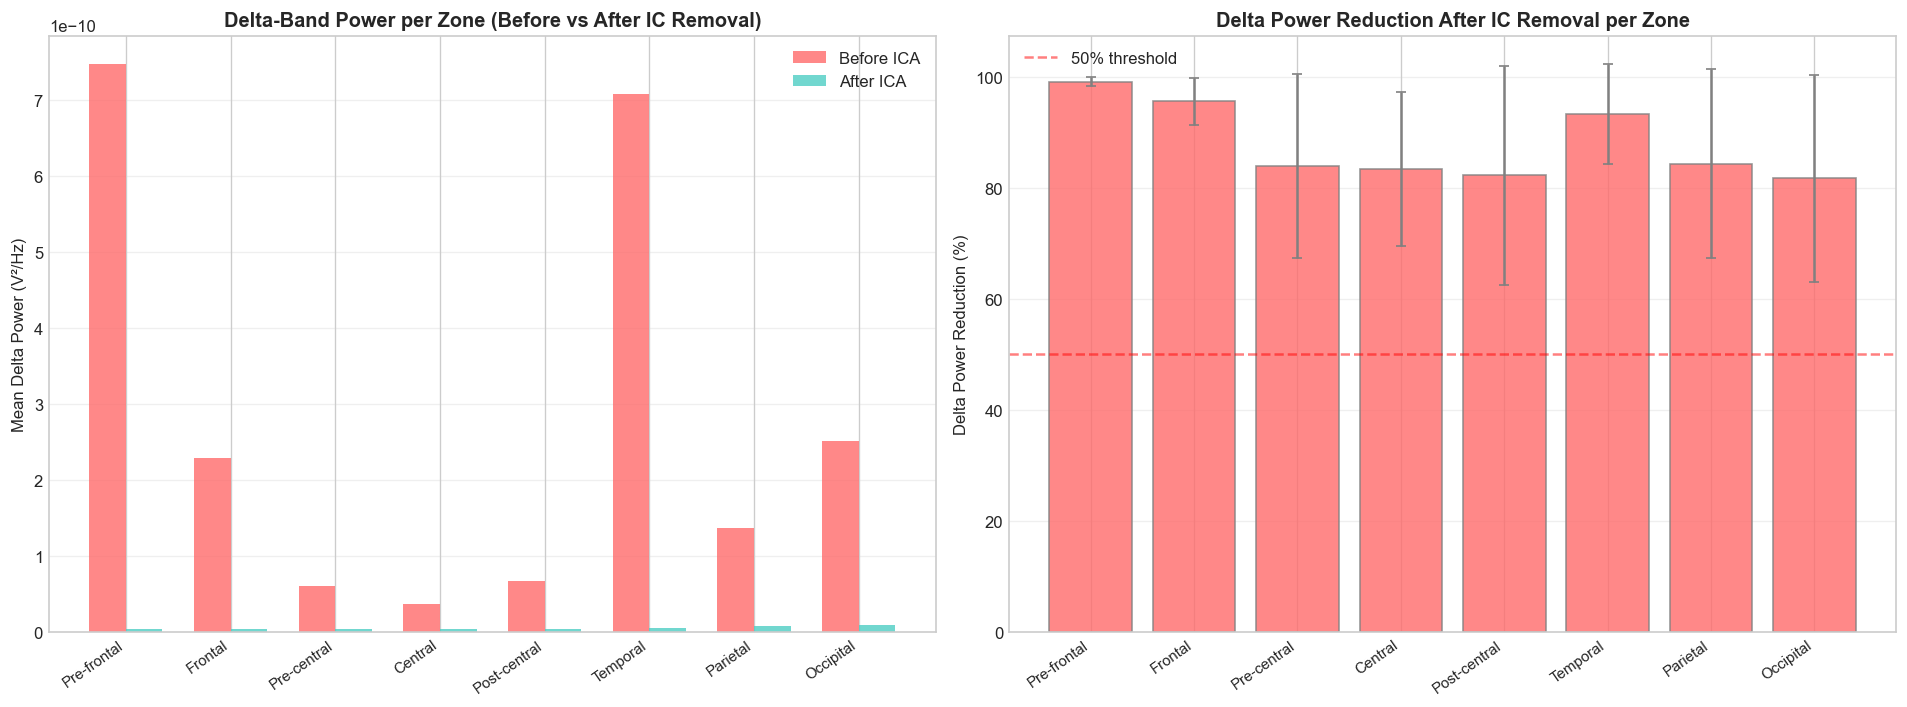


ZONE-LEVEL DELTA POWER REDUCTION AFTER IC REMOVAL
  Pre-frontal    :  99.2% ±  0.9% ⚠ HIGH
  Frontal        :  95.6% ±  4.2% ⚠ HIGH
  Pre-central    :  84.0% ± 16.5% ⚠ HIGH
  Central        :  83.4% ± 13.9% ⚠ HIGH
  Post-central   :  82.3% ± 19.8% ⚠ HIGH
  Temporal       :  93.3% ±  9.0% ⚠ HIGH
  Parietal       :  84.4% ± 17.0% ⚠ HIGH
  Occipital      :  81.7% ± 18.7% ⚠ HIGH

🔑 Zones with HIGH reduction (>40%) were heavily driven by artifact ICs.
   These zones' SHAP importance in FAST was likely artifact-inflated.


In [10]:
# --------------------------------------------------------------------------
# Measure zone-level delta power before/after removing delta-dominant ICs
# --------------------------------------------------------------------------

def compute_zone_band_power(raw_obj, zones, electrodes, sfreq, band=(0.5, 4)):
    """Compute mean power in a frequency band for each brain zone."""
    data = raw_obj.get_data()  # (n_channels, n_times)
    zone_powers = {}
    
    for zone_name, zone_chs in zones.items():
        ch_indices = [electrodes.index(ch) for ch in zone_chs if ch in electrodes]
        if len(ch_indices) == 0:
            zone_powers[zone_name] = 0
            continue
        
        zone_data = data[ch_indices]
        freqs, psd = signal.welch(zone_data, fs=sfreq, nperseg=512, noverlap=256)
        band_mask = (freqs >= band[0]) & (freqs <= band[1])
        zone_powers[zone_name] = np.mean(psd[:, band_mask])
    
    return zone_powers


# Process all subjects
zone_names = list(ZONES.keys())
before_all = {z: [] for z in zone_names}
after_all  = {z: [] for z in zone_names}
reduction_all = {z: [] for z in zone_names}

for sid in sorted(ica_results.keys()):
    ica = ica_results[sid]['ica']
    raw_filt = ica_results[sid]['raw_filt']
    ic_info_list = ic_spectral_data[sid]
    
    # Identify delta-dominant ICs to exclude
    delta_ics = [ic['ic_idx'] for ic in ic_info_list if ic['delta_dominant']]
    
    # --- Before: Original data (1 Hz filtered) ---
    powers_before = compute_zone_band_power(raw_filt, ZONES, ELECTRODES, SFREQ, band=(0.5, 4))
    
    # --- After: Remove delta-dominant ICs ---
    if len(delta_ics) > 0:
        raw_clean = raw_filt.copy()
        ica.apply(raw_clean, exclude=delta_ics, verbose=False)
        powers_after = compute_zone_band_power(raw_clean, ZONES, ELECTRODES, SFREQ, band=(0.5, 4))
    else:
        powers_after = powers_before.copy()
    
    for z in zone_names:
        before_all[z].append(powers_before[z])
        after_all[z].append(powers_after[z])
        if powers_before[z] > 0:
            reduction_all[z].append((1 - powers_after[z] / powers_before[z]) * 100)
        else:
            reduction_all[z].append(0)

# --------------------------------------------------------------------------
# Visualization: Before vs After delta power per zone
# --------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: Mean delta power before/after
x = np.arange(len(zone_names))
width = 0.35
means_before = [np.mean(before_all[z]) for z in zone_names]
means_after  = [np.mean(after_all[z]) for z in zone_names]

axes[0].bar(x - width/2, means_before, width, label='Before ICA', color='#ff6b6b', alpha=0.8)
axes[0].bar(x + width/2, means_after,  width, label='After ICA',  color='#4ecdc4', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(zone_names, rotation=35, ha='right', fontsize=9)
axes[0].set_ylabel('Mean Delta Power (V²/Hz)')
axes[0].set_title('Delta-Band Power per Zone (Before vs After IC Removal)', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Bar chart: % reduction
mean_reductions = [np.mean(reduction_all[z]) for z in zone_names]
std_reductions  = [np.std(reduction_all[z]) for z in zone_names]
colors = ['#ff6b6b' if r > 40 else '#ffd93d' if r > 20 else '#4ecdc4' for r in mean_reductions]

axes[1].bar(x, mean_reductions, color=colors, alpha=0.8, edgecolor='gray')
axes[1].errorbar(x, mean_reductions, yerr=std_reductions, fmt='none', ecolor='gray', capsize=3)
axes[1].set_xticks(x)
axes[1].set_xticklabels(zone_names, rotation=35, ha='right', fontsize=9)
axes[1].set_ylabel('Delta Power Reduction (%)')
axes[1].set_title('Delta Power Reduction After IC Removal per Zone', fontweight='bold')
axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*65)
print("ZONE-LEVEL DELTA POWER REDUCTION AFTER IC REMOVAL")
print("="*65)
for z in zone_names:
    mr = np.mean(reduction_all[z])
    flag = " ⚠ HIGH" if mr > 40 else ""
    print(f"  {z:<15}: {mr:5.1f}% ± {np.std(reduction_all[z]):4.1f}%{flag}")
print("="*65)
print("\n🔑 Zones with HIGH reduction (>40%) were heavily driven by artifact ICs.")
print("   These zones' SHAP importance in FAST was likely artifact-inflated.")

# 10. Full Spectral Comparison: Before vs After ICA Cleaning

We compare the **complete PSD** (all bands) before and after removing delta-dominant ICs.
This shows whether the cleaning preserves the higher-frequency neural content (alpha, beta, gamma)
that the model *should* be relying on for imagined speech classification.

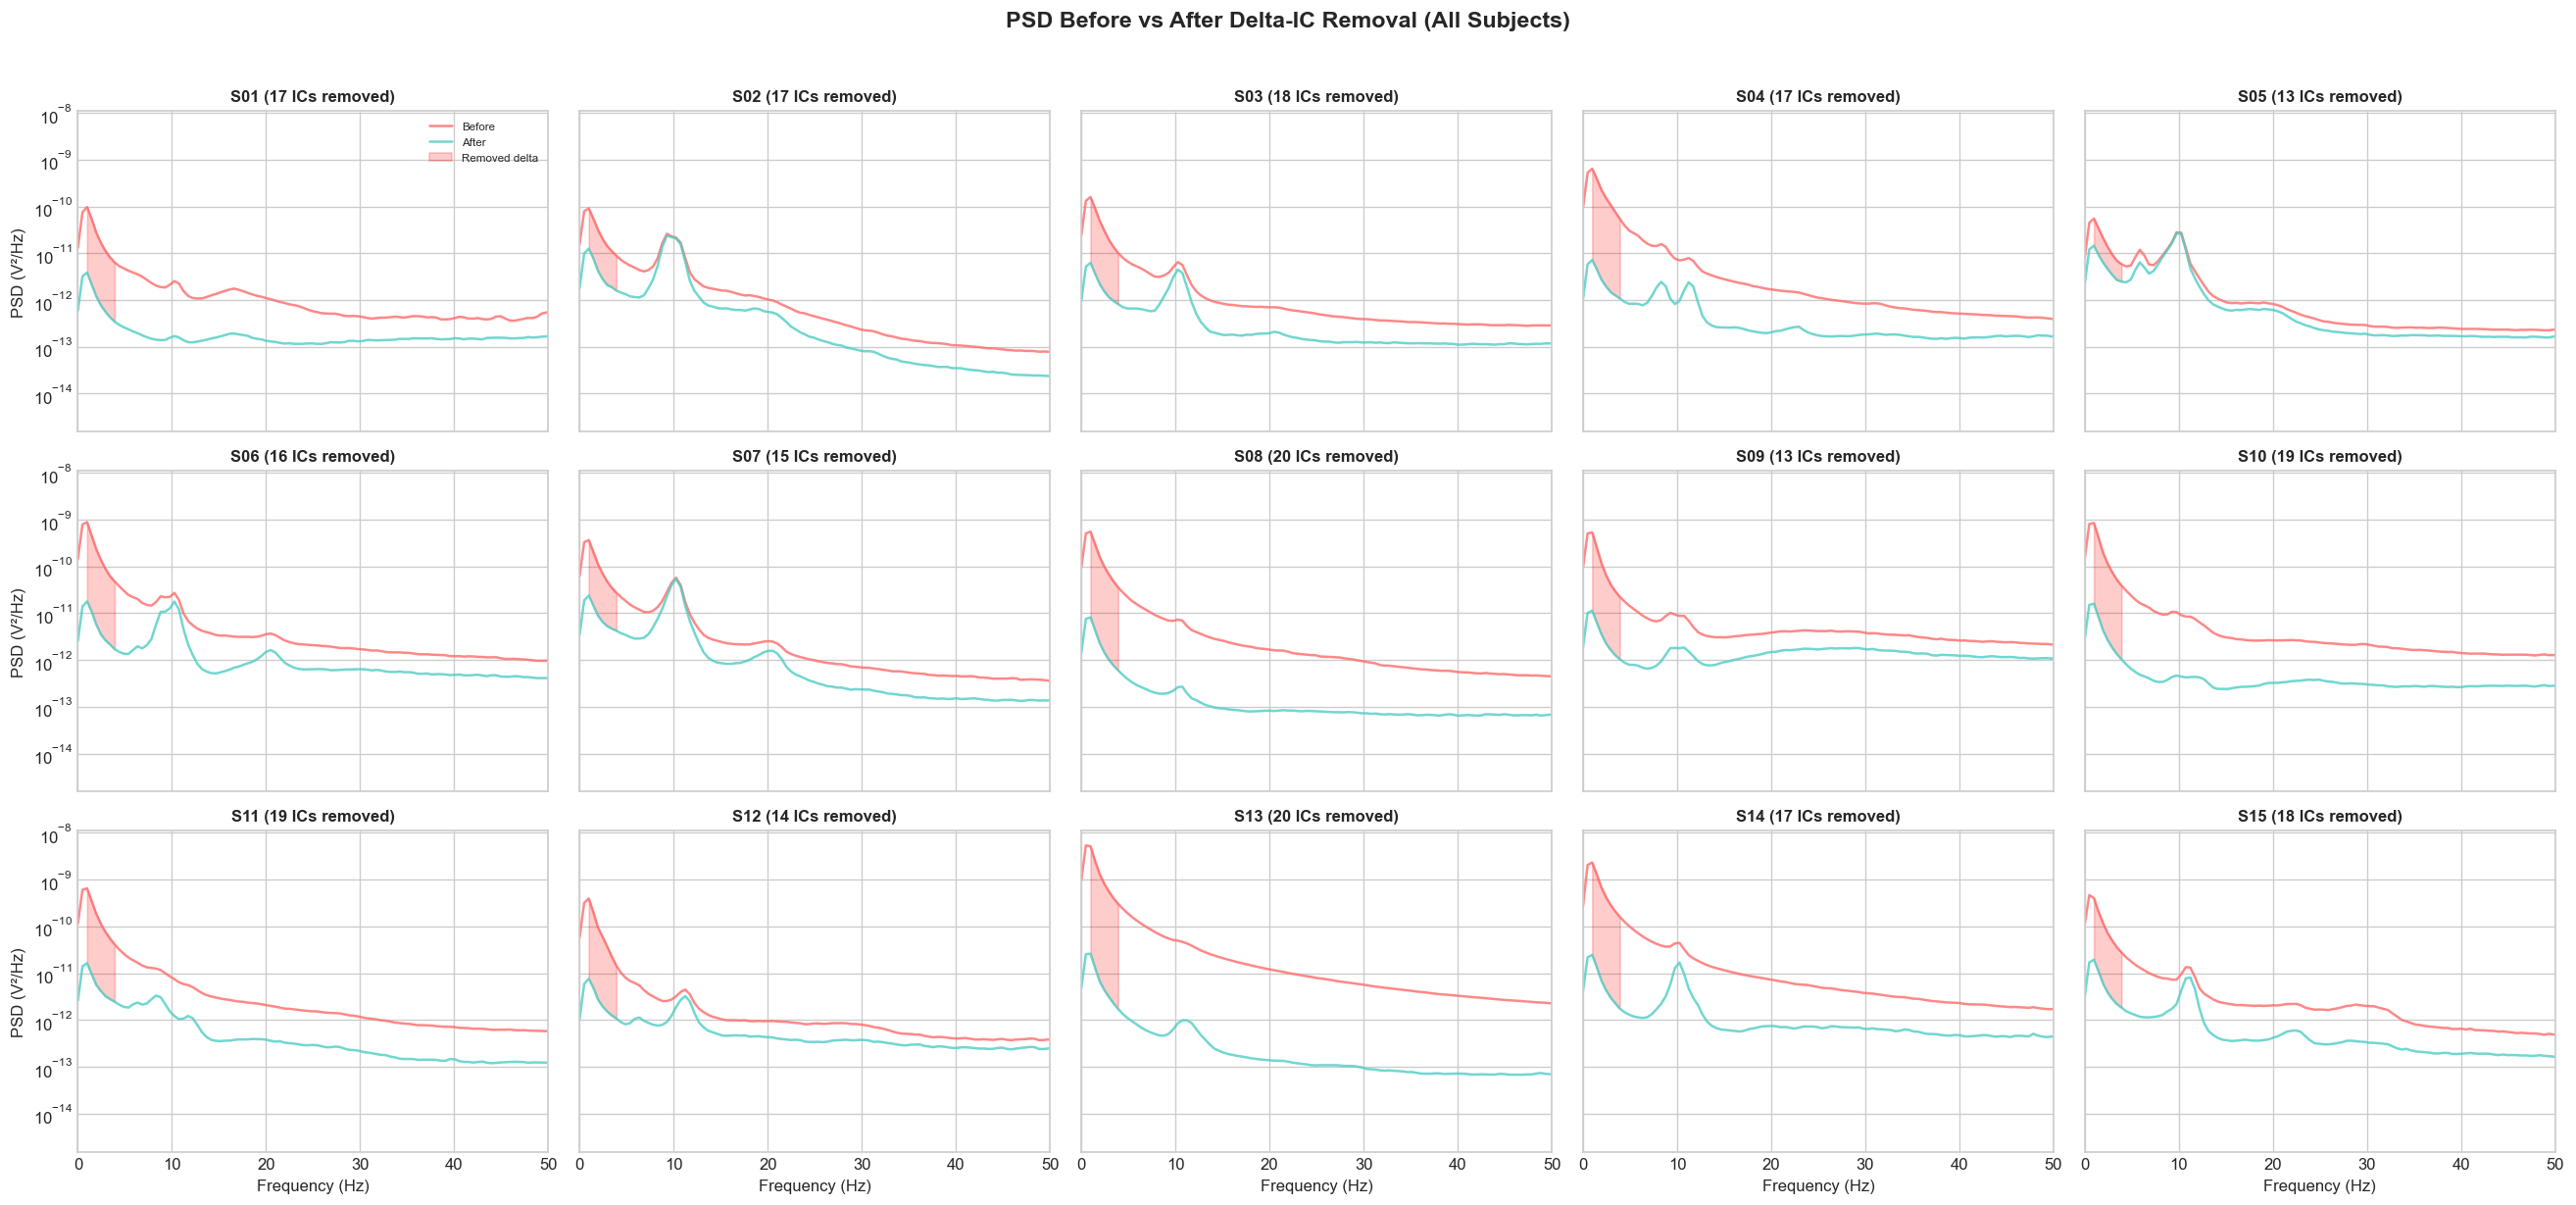

✓ Red shading shows the delta power that was removed.
  Higher-frequency bands (alpha, beta, gamma) should remain intact.


In [11]:
# --------------------------------------------------------------------------
# Full PSD comparison: before vs after delta-IC removal
# --------------------------------------------------------------------------

fig, axes = plt.subplots(3, 5, figsize=(22, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, sid in enumerate(sorted(ica_results.keys())):
    ica = ica_results[sid]['ica']
    raw_filt = ica_results[sid]['raw_filt']
    ic_info_list = ic_spectral_data[sid]
    
    delta_ics = [ic['ic_idx'] for ic in ic_info_list if ic['delta_dominant']]
    
    # Before: original filtered data
    data_before = raw_filt.get_data()
    freqs_b, psd_b = signal.welch(data_before, fs=SFREQ, nperseg=512, noverlap=256)
    mean_psd_b = psd_b.mean(axis=0)
    
    # After: cleaned data
    if len(delta_ics) > 0:
        raw_clean = raw_filt.copy()
        ica.apply(raw_clean, exclude=delta_ics, verbose=False)
        data_after = raw_clean.get_data()
    else:
        data_after = data_before
    
    freqs_a, psd_a = signal.welch(data_after, fs=SFREQ, nperseg=512, noverlap=256)
    mean_psd_a = psd_a.mean(axis=0)
    
    ax = axes[idx]
    ax.semilogy(freqs_b, mean_psd_b, color='#ff6b6b', linewidth=1.5, alpha=0.8, label='Before')
    ax.semilogy(freqs_a, mean_psd_a, color='#4ecdc4', linewidth=1.5, alpha=0.8, label='After')
    
    # Shade delta region
    delta_mask = (freqs_b >= 0.5) & (freqs_b <= 4)
    ax.fill_between(freqs_b[delta_mask], mean_psd_b[delta_mask], mean_psd_a[delta_mask],
                    alpha=0.2, color='red', label='Removed delta')
    
    ax.set_title(f'S{sid} ({len(delta_ics)} ICs removed)', fontsize=10, fontweight='bold')
    ax.set_xlim(0, 50)
    
    if idx == 0:
        ax.legend(fontsize=7, loc='upper right')
    if idx >= 10:
        ax.set_xlabel('Frequency (Hz)')
    if idx % 5 == 0:
        ax.set_ylabel('PSD (V²/Hz)')

plt.suptitle('PSD Before vs After Delta-IC Removal (All Subjects)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Red shading shows the delta power that was removed.")
print("  Higher-frequency bands (alpha, beta, gamma) should remain intact.")

# 11. Subject-Level Delta Fingerprint Analysis

If FAST is overfitting, it may be learning **subject-specific delta fingerprints** —
unique low-frequency baseline patterns that identify the subject rather than the
imagined speech class.

Here we test this by computing each subject's average delta-band topography and
measuring how distinguishable subjects are based on delta alone.
If subjects are highly distinguishable, the model can trivially overfit to individual
baselines rather than learning class-discriminative features.

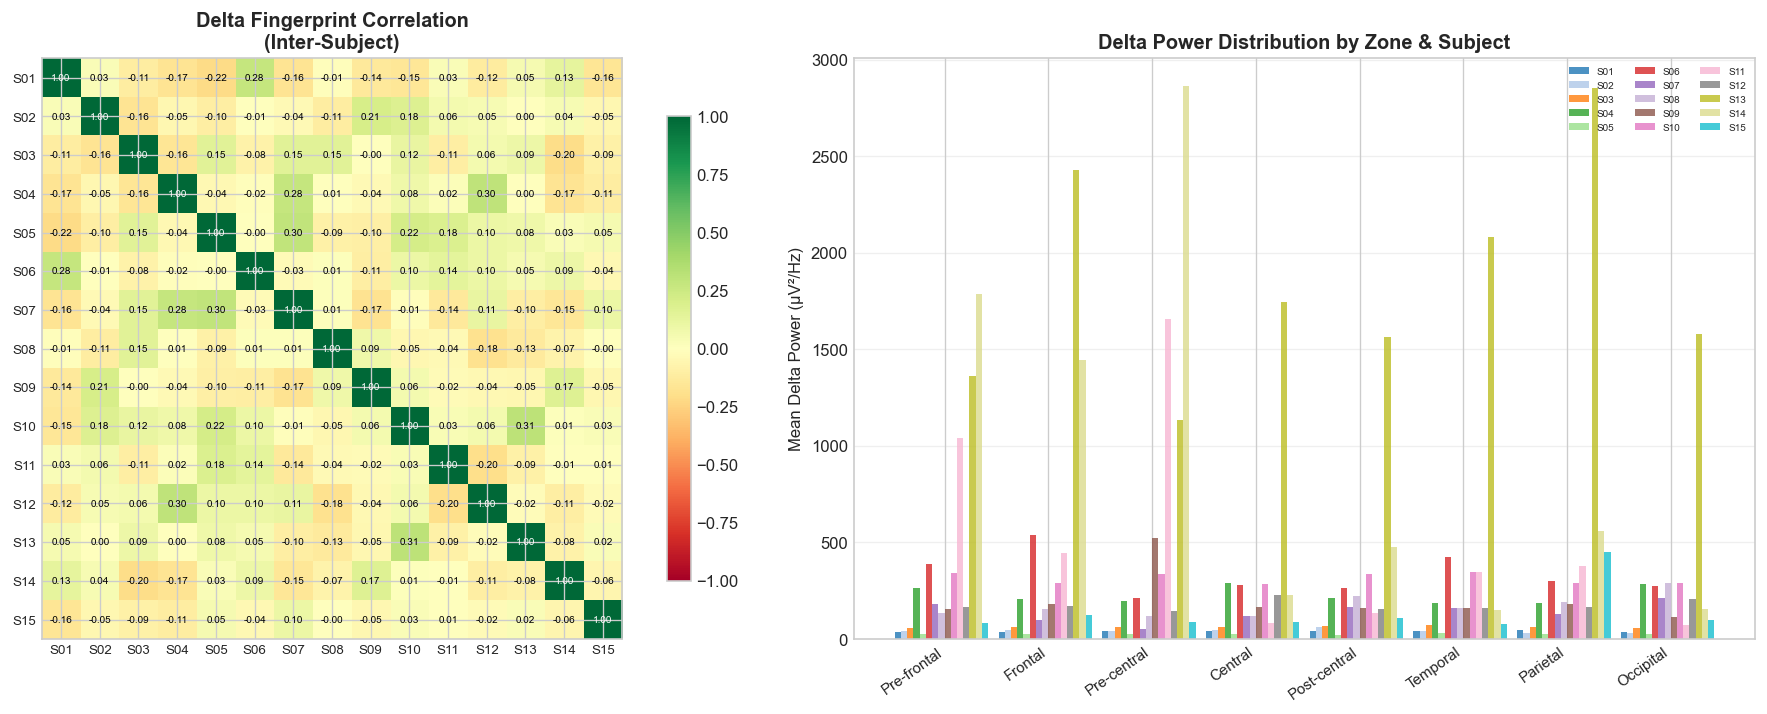


Delta fingerprint inter-subject correlation: -0.001 ± 0.119

🔴 LOW correlation → Each subject has a unique delta topography.
  This is a strong signal that FAST can trivially identify subjects via delta baselines.
  This likely contributes to overfitting and poor cross-subject generalization.


In [12]:
# --------------------------------------------------------------------------
# Subject-level delta fingerprinting
# --------------------------------------------------------------------------

def compute_channel_band_power(X_subject, sfreq, band):
    """Compute mean power per channel in a given band across all trials.
    
    Args:
        X_subject: (n_trials, n_channels, n_timepoints)
        sfreq: sampling frequency
        band: (low, high) frequency limits
        
    Returns:
        (n_channels,) array of mean band power per channel
    """
    # Average across trials first, then compute PSD per channel
    continuous = X_subject.reshape(X_subject.shape[1], -1)  # (64, trials*timepoints)
    freqs, psd = signal.welch(continuous, fs=sfreq, nperseg=512, noverlap=256)
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    return psd[:, band_mask].mean(axis=1)  # (64,)


# Compute delta fingerprint for each subject
delta_fingerprints = {}
for sid in sorted(train_data.keys()):
    X_sub = train_data[sid][0]
    delta_fingerprints[sid] = compute_channel_band_power(X_sub, SFREQ, (0.5, 4))

# --- A) Inter-subject correlation matrix of delta fingerprints ---
subject_ids = sorted(delta_fingerprints.keys())
n = len(subject_ids)
fp_corr = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        fp_corr[i, j] = np.corrcoef(
            delta_fingerprints[subject_ids[i]],
            delta_fingerprints[subject_ids[j]]
        )[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im = axes[0].imshow(fp_corr, cmap='RdYlGn', vmin=-1, vmax=1, aspect='equal')
axes[0].set_xticks(range(n))
axes[0].set_xticklabels([f'S{s}' for s in subject_ids], fontsize=8)
axes[0].set_yticks(range(n))
axes[0].set_yticklabels([f'S{s}' for s in subject_ids], fontsize=8)
axes[0].set_title('Delta Fingerprint Correlation\n(Inter-Subject)', fontweight='bold')
plt.colorbar(im, ax=axes[0], shrink=0.8)

for i in range(n):
    for j in range(n):
        axes[0].text(j, i, f'{fp_corr[i,j]:.2f}', ha='center', va='center',
                     fontsize=6, color='white' if abs(fp_corr[i,j]) > 0.6 else 'black')

# --- B) Topographic maps of delta fingerprints for a few subjects ---
# We'll use a bar chart of zone-averaged delta power per subject instead
zone_delta = {}
for sid in subject_ids:
    fp = delta_fingerprints[sid]
    zone_delta[sid] = {}
    for zone_name, zone_chs in ZONES.items():
        ch_indices = [ELECTRODES.index(ch) for ch in zone_chs if ch in ELECTRODES]
        zone_delta[sid][zone_name] = fp[ch_indices].mean()

# Grouped bar chart
zone_names = list(ZONES.keys())
x = np.arange(len(zone_names))
width = 0.06
cmap = plt.cm.tab20

for i, sid in enumerate(subject_ids):
    values = [zone_delta[sid][z] for z in zone_names]
    axes[1].bar(x + i * width, values, width, label=f'S{sid}',
                color=cmap(i / n), alpha=0.8)

axes[1].set_xticks(x + width * n / 2)
axes[1].set_xticklabels(zone_names, rotation=35, ha='right', fontsize=9)
axes[1].set_ylabel('Mean Delta Power (µV²/Hz)')
axes[1].set_title('Delta Power Distribution by Zone & Subject', fontweight='bold')
axes[1].legend(fontsize=6, ncol=3, loc='upper right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --- C) Quantify subject distinguishability ---
off_diag = fp_corr[np.triu_indices(n, k=1)]
print(f"\nDelta fingerprint inter-subject correlation: {off_diag.mean():.3f} ± {off_diag.std():.3f}")

if off_diag.mean() > 0.8:
    print("\n⚠ VERY HIGH correlation → Delta topographies are nearly identical across subjects.")
    print("  The model cannot easily use delta to distinguish subjects (good for generalization).")
    print("  But the uniform delta dominance may still cause class-agnostic overfitting.")
elif off_diag.mean() > 0.5:
    print("\n⚡ MODERATE correlation → Some shared delta patterns but also subject-specific variation.")
    print("  Enough variation for the model to partially learn subject identity through delta.")
else:
    print("\n🔴 LOW correlation → Each subject has a unique delta topography.")
    print("  This is a strong signal that FAST can trivially identify subjects via delta baselines.")
    print("  This likely contributes to overfitting and poor cross-subject generalization.")

# 12. Class-Conditional Delta Analysis

The final critical test: does delta power differ **between imagined speech classes**?

- If YES → delta carries class-discriminative information (may be genuine slow cortical potentials)
- If NO → delta is class-agnostic noise that the model should NOT be relying on

We compute delta power per class per subject and run a statistical comparison.

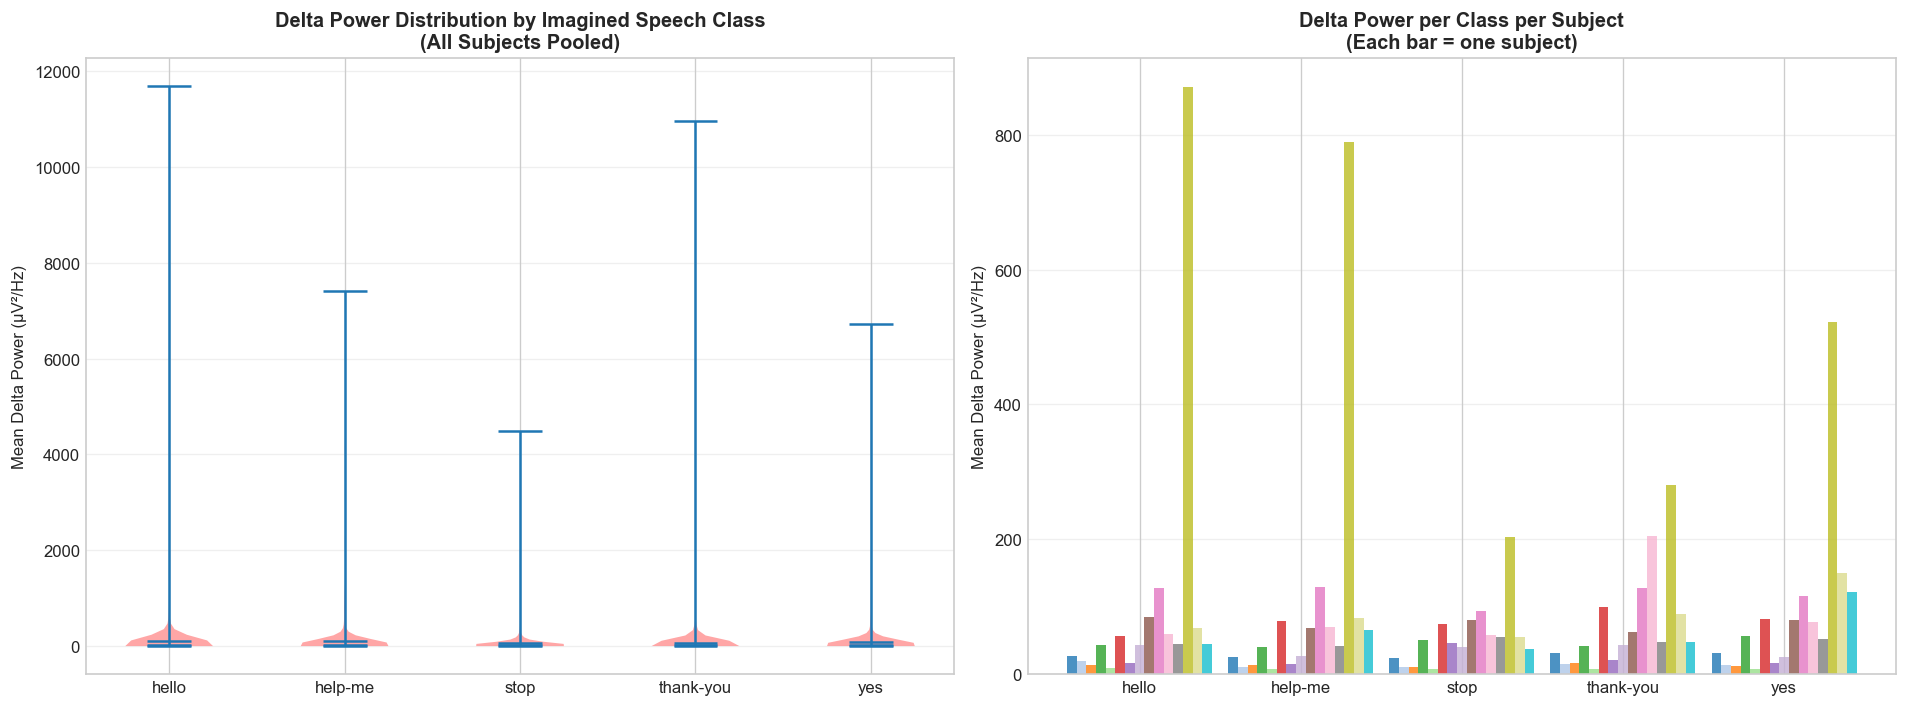


STATISTICAL TEST: Class-Conditional Delta Power

  One-Way ANOVA:     F = 2.2702, p = 0.059255
  Kruskal-Wallis:    H = 3.6139, p = 0.460775

  Per-class mean delta power:
    hello       : 101.6123 ± 557.7421
    help-me     : 97.4563 ± 410.8455
    stop        : 56.2874 ± 178.9688
    thank-you   : 75.7684 ± 377.3101
    yes         : 90.8432 ± 372.5516

  ⚠ p ≥ 0.05 → Delta power is NOT class-discriminative.
    The model's reliance on delta is almost certainly artifact-driven.
    Removing delta ICs or filtering should IMPROVE generalization without losing signal.

  Between-CLASS variance:   274.61361694
  Between-SUBJECT variance: 15405.59082031
  Subject/Class ratio:      56.1x

  🔴 Subject variability is 56x larger than class variability in delta.
     → The model primarily uses delta to distinguish SUBJECTS, not CLASSES.
     → This is the root cause of overfitting and poor generalization.


In [13]:
# --------------------------------------------------------------------------
# Class-conditional delta power analysis
# --------------------------------------------------------------------------
from scipy.stats import f_oneway, kruskal

class_delta_powers = {c: [] for c in range(5)}  # per-class across all subjects
class_delta_per_subject = {}  # {sid: {class_id: [trial_powers]}}

for sid in sorted(train_data.keys()):
    X_sub, Y_sub = train_data[sid]
    class_delta_per_subject[sid] = {}
    
    for class_id in range(5):
        # Select trials belonging to this class
        class_mask = (Y_sub == class_id)
        X_class = X_sub[class_mask]  # (n_trials_class, 64, 800)
        
        if len(X_class) == 0:
            continue
        
        # Compute delta power per trial (average across channels)
        trial_delta_powers = []
        for trial in X_class:
            freqs, psd = signal.welch(trial, fs=SFREQ, nperseg=256, noverlap=128)
            delta_mask = (freqs >= 0.5) & (freqs <= 4)
            trial_delta = psd[:, delta_mask].mean()
            trial_delta_powers.append(trial_delta)
        
        class_delta_per_subject[sid][class_id] = trial_delta_powers
        class_delta_powers[class_id].extend(trial_delta_powers)

# --------------------------------------------------------------------------
# Visualization: Class-conditional delta power distribution
# --------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A) Violin plot of delta power per class (all subjects pooled)
positions = range(5)
data_for_violin = [class_delta_powers[c] for c in range(5)]

vp = axes[0].violinplot(data_for_violin, positions=positions, showmeans=True, showmedians=True)
for pc in vp['bodies']:
    pc.set_facecolor('#ff6b6b')
    pc.set_alpha(0.6)

axes[0].set_xticks(positions)
axes[0].set_xticklabels(CLASSES, fontsize=10)
axes[0].set_ylabel('Mean Delta Power (µV²/Hz)')
axes[0].set_title('Delta Power Distribution by Imagined Speech Class\n(All Subjects Pooled)',
                   fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# B) Per-subject class means (shows inter-subject variability)
class_means_per_sub = {c: [] for c in range(5)}
for sid in sorted(class_delta_per_subject.keys()):
    for c in range(5):
        if c in class_delta_per_subject[sid]:
            class_means_per_sub[c].append(np.mean(class_delta_per_subject[sid][c]))

x = np.arange(5)
width = 0.06
cmap_sub = plt.cm.tab20

for i, sid in enumerate(sorted(class_delta_per_subject.keys())):
    values = []
    for c in range(5):
        if c in class_delta_per_subject[sid]:
            values.append(np.mean(class_delta_per_subject[sid][c]))
        else:
            values.append(0)
    axes[1].bar(x + i * width, values, width, color=cmap_sub(i / 15), alpha=0.8)

axes[1].set_xticks(x + width * 7)
axes[1].set_xticklabels(CLASSES, fontsize=10)
axes[1].set_ylabel('Mean Delta Power (µV²/Hz)')
axes[1].set_title('Delta Power per Class per Subject\n(Each bar = one subject)', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------
# Statistical test: Is delta power class-discriminative?
# --------------------------------------------------------------------------
print("\n" + "="*65)
print("STATISTICAL TEST: Class-Conditional Delta Power")
print("="*65)

# ANOVA across classes (pooled across subjects)
stat_f, p_anova = f_oneway(*[class_delta_powers[c] for c in range(5)])
stat_h, p_kruskal = kruskal(*[class_delta_powers[c] for c in range(5)])

print(f"\n  One-Way ANOVA:     F = {stat_f:.4f}, p = {p_anova:.6f}")
print(f"  Kruskal-Wallis:    H = {stat_h:.4f}, p = {p_kruskal:.6f}")

# Per-class means
print(f"\n  Per-class mean delta power:")
for c in range(5):
    m = np.mean(class_delta_powers[c])
    s = np.std(class_delta_powers[c])
    print(f"    {CLASSES[c]:<12}: {m:.4f} ± {s:.4f}")

# Interpretation
if p_anova < 0.01:
    print(f"\n  ✓ p < 0.01 → Delta power IS significantly class-discriminative.")
    print(f"    Some delta activity may carry genuine task-related information.")
    print(f"    However, effect size matters — check if differences are practically meaningful.")
elif p_anova < 0.05:
    print(f"\n  ⚡ p < 0.05 → Weak evidence of class discrimination in delta.")
    print(f"    Delta may carry marginal task information, but artifact contribution is likely dominant.")
else:
    print(f"\n  ⚠ p ≥ 0.05 → Delta power is NOT class-discriminative.")
    print(f"    The model's reliance on delta is almost certainly artifact-driven.")
    print(f"    Removing delta ICs or filtering should IMPROVE generalization without losing signal.")

# Inter-subject variability vs inter-class variability
between_class_var = np.var([np.mean(class_delta_powers[c]) for c in range(5)])
between_subject_var = np.var([np.mean(np.concatenate(
    [class_delta_per_subject[sid].get(c, [0]) for c in range(5)]
)) for sid in sorted(class_delta_per_subject.keys())])

print(f"\n  Between-CLASS variance:   {between_class_var:.8f}")
print(f"  Between-SUBJECT variance: {between_subject_var:.8f}")
ratio = between_subject_var / between_class_var if between_class_var > 0 else float('inf')
print(f"  Subject/Class ratio:      {ratio:.1f}x")

if ratio > 5:
    print(f"\n  🔴 Subject variability is {ratio:.0f}x larger than class variability in delta.")
    print(f"     → The model primarily uses delta to distinguish SUBJECTS, not CLASSES.")
    print(f"     → This is the root cause of overfitting and poor generalization.")

# 13. Export ICA-Cleaned Data for Ablation Experiments

We save two versions of the cleaned data to HDF5 files that can be used directly
with your FAST training pipeline for A/B comparison:

- **Condition B**: Remove all delta-dominant ICs
- **Condition C**: Remove only ICs classified as artifact (frontal ocular + diffuse)

You can then retrain FAST on each and compare accuracy, overfitting, and SHAP attribution shifts.

In [14]:
# --------------------------------------------------------------------------
# Export ICA-cleaned datasets for FAST retraining
# --------------------------------------------------------------------------

OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'Processed')

# Condition B: Remove ALL delta-dominant ICs
H5_COND_B = os.path.join(OUTPUT_DIR, 'BCIC2020Track3_ICA_no_delta.h5')

# Condition C: Remove only artifact-classified delta ICs (frontal/diffuse)
H5_COND_C = os.path.join(OUTPUT_DIR, 'BCIC2020Track3_ICA_no_artifacts.h5')

ARTIFACT_LABELS = ['Frontal (likely ocular)', 'Temporal (likely muscle)', 'Diffuse (likely drift/ref)']

def export_cleaned_h5(output_path, ica_results_dict, ic_spectral_dict,
                       train_data_dict, exclude_mode='all_delta',
                       artifact_classifications=None):
    """
    Apply ICA cleaning and save to HDF5 in the same format as the original cache.
    
    exclude_mode:
        'all_delta'   — remove all delta-dominant ICs
        'artifacts'   — remove only ICs classified as artifact
    """
    with h5py.File(output_path, 'w') as f_out:
        for sid in sorted(ica_results_dict.keys()):
            ica = ica_results_dict[sid]['ica']
            raw_filt = ica_results_dict[sid]['raw_filt']
            ic_info_list = ic_spectral_dict[sid]
            X_orig, Y_orig = train_data_dict[sid]
            n_trials, n_ch, n_time = X_orig.shape
            
            # Determine which ICs to exclude
            if exclude_mode == 'all_delta':
                exclude_ics = [ic['ic_idx'] for ic in ic_info_list if ic['delta_dominant']]
            elif exclude_mode == 'artifacts':
                exclude_ics = []
                if artifact_classifications and sid in artifact_classifications:
                    for ic_idx, label, _ in artifact_classifications[sid]:
                        if any(al in label for al in ARTIFACT_LABELS):
                            exclude_ics.append(ic_idx)
            else:
                exclude_ics = []
            
            # Apply ICA cleaning
            if len(exclude_ics) > 0:
                raw_clean = raw_filt.copy()
                ica.apply(raw_clean, exclude=exclude_ics, verbose=False)
                cleaned_data = raw_clean.get_data()  # (64, total_time) in Volts
            else:
                cleaned_data = raw_filt.get_data()
            
            # Convert back to µV
            cleaned_data = cleaned_data * 1e6
            
            # Reshape back to (n_trials, n_channels, n_timepoints)
            X_cleaned = cleaned_data.reshape(n_ch, n_trials, n_time).transpose(1, 0, 2)
            X_cleaned = X_cleaned.astype(np.float32)
            
            # Save
            grp = f_out.create_group(sid)
            grp.create_dataset('X', data=X_cleaned)
            grp.create_dataset('Y', data=Y_orig)
            
            print(f"  S{sid}: Removed {len(exclude_ics)} ICs, output shape {X_cleaned.shape}")
    
    print(f"\n✓ Saved to {output_path}")


# --- Export Condition B: No delta ICs ---
print("="*60)
print("CONDITION B: Removing ALL delta-dominant ICs")
print("="*60)
export_cleaned_h5(H5_COND_B, ica_results, ic_spectral_data, train_data,
                  exclude_mode='all_delta')

# --- Export Condition C: No artifact ICs ---
print(f"\n{'='*60}")
print("CONDITION C: Removing artifact-classified delta ICs only")
print("="*60)
export_cleaned_h5(H5_COND_C, ica_results, ic_spectral_data, train_data,
                  exclude_mode='artifacts', artifact_classifications=all_classifications)

print(f"\n{'='*60}")
print("EXPORTED FILES:")
print(f"  Original:     {H5_TRAIN}")
print(f"  Condition B:  {H5_COND_B}")
print(f"  Condition C:  {H5_COND_C}")
print(f"{'='*60}")
print("\nYou can now retrain FAST on each file and compare:")
print("  1. Accuracy (intra-subject)")
print("  2. Cross-subject generalization")
print("  3. SHAP attribution shifts (should move away from delta)")

CONDITION B: Removing ALL delta-dominant ICs
  S01: Removed 17 ICs, output shape (350, 64, 800)
  S02: Removed 17 ICs, output shape (350, 64, 800)
  S03: Removed 18 ICs, output shape (350, 64, 800)
  S04: Removed 17 ICs, output shape (350, 64, 800)
  S05: Removed 13 ICs, output shape (350, 64, 800)
  S06: Removed 16 ICs, output shape (350, 64, 800)
  S07: Removed 15 ICs, output shape (350, 64, 800)
  S08: Removed 20 ICs, output shape (350, 64, 800)
  S09: Removed 13 ICs, output shape (350, 64, 800)
  S10: Removed 19 ICs, output shape (350, 64, 800)
  S11: Removed 19 ICs, output shape (350, 64, 800)
  S12: Removed 14 ICs, output shape (350, 64, 800)
  S13: Removed 20 ICs, output shape (350, 64, 800)
  S14: Removed 17 ICs, output shape (350, 64, 800)
  S15: Removed 18 ICs, output shape (350, 64, 800)

✓ Saved to /home/kay/FAST/Processed/BCIC2020Track3_ICA_no_delta.h5

CONDITION C: Removing artifact-classified delta ICs only
  S01: Removed 9 ICs, output shape (350, 64, 800)
  S02: Removed

# 14. Summary Dashboard

A single consolidated view of all key findings from this ICA analysis.

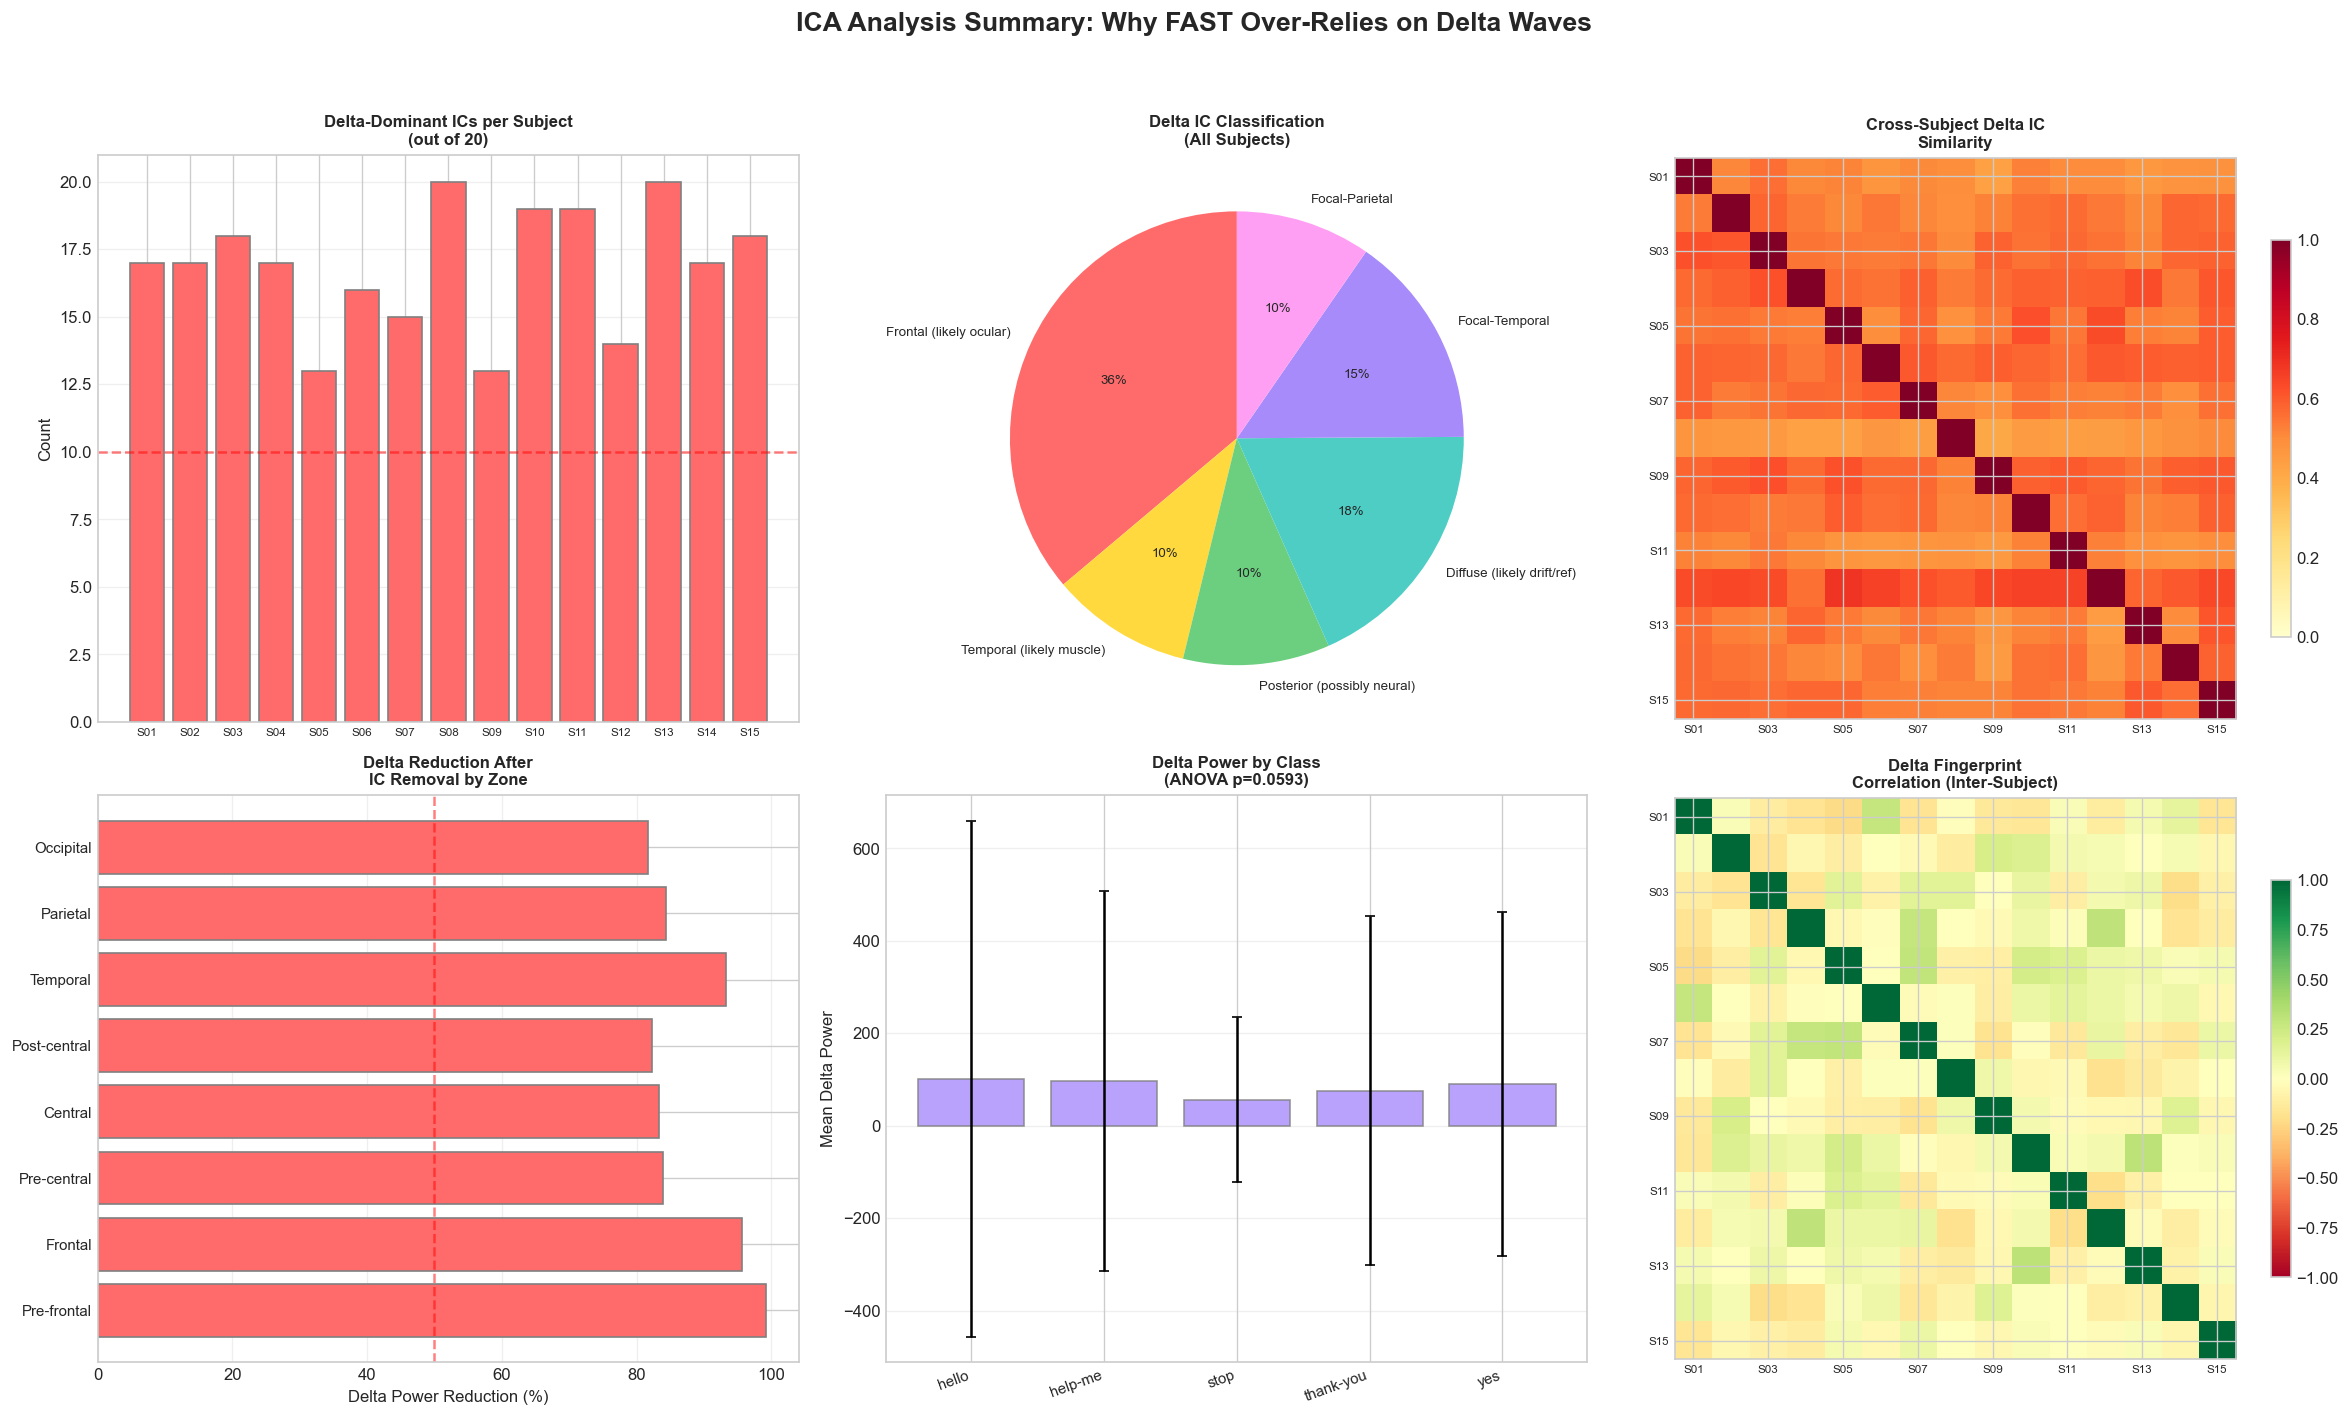


ICA ANALYSIS: KEY FINDINGS

1. DELTA IC PREVALENCE
   17/20 ICs per subject are delta-dominant on average.
   → 84% of independent sources are low-frequency.

2. IC CLASSIFICATION
   Most delta ICs are: Frontal (likely ocular)
   → This tells us the primary source of delta activity in the data.

3. CROSS-SUBJECT CONSISTENCY
   Mean inter-subject delta-IC similarity: -0.001
   → LOW: 
   delta patterns are subject-specific.

4. CLASS DISCRIMINATION
   ANOVA p-value: 0.059255
   → Delta is NOT class-discriminative.
   Subject variability is 56x larger than class variability in delta.

5. RECOMMENDATIONS
   → Remove artifact-classified delta ICs before training.
   → Retrain FAST on ICA-cleaned data (Condition B/C files exported).
   → Re-run SHAP to verify attribution shifts away from delta.
   → Consider adding spectral regularization or delta-attenuation augmentation.



In [15]:
# ==========================================================================
# SUMMARY DASHBOARD
# ==========================================================================

fig = plt.figure(figsize=(20, 12))
fig.suptitle('ICA Analysis Summary: Why FAST Over-Relies on Delta Waves',
             fontsize=16, fontweight='bold', y=0.98)

# --- Panel 1: Delta IC counts per subject ---
ax1 = fig.add_subplot(2, 3, 1)
sids = sorted(ic_spectral_data.keys())
delta_counts = [sum(1 for ic in ic_spectral_data[s] if ic['delta_dominant']) for s in sids]
colors_bar = ['#ff6b6b' if d > N_COMPONENTS * 0.5 else '#ffd93d' for d in delta_counts]
ax1.bar(range(len(sids)), delta_counts, color=colors_bar, edgecolor='gray')
ax1.set_xticks(range(len(sids)))
ax1.set_xticklabels([f'S{s}' for s in sids], fontsize=7)
ax1.set_ylabel('Count')
ax1.set_title(f'Delta-Dominant ICs per Subject\n(out of {N_COMPONENTS})', fontweight='bold', fontsize=10)
ax1.axhline(y=N_COMPONENTS * 0.5, color='red', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)

# --- Panel 2: IC classification pie chart ---
ax2 = fig.add_subplot(2, 3, 2)
labels_pie = list(classification_summary.keys())
sizes_pie = list(classification_summary.values())
colors_pie = ['#ff6b6b', '#ffd93d', '#6bcf7f', '#4ecdc4', '#a78bfa', '#ff9ff3']
ax2.pie(sizes_pie[:len(colors_pie)], labels=labels_pie[:len(colors_pie)],
        colors=colors_pie[:len(sizes_pie)],
        autopct='%1.0f%%', startangle=90, textprops={'fontsize': 8})
ax2.set_title('Delta IC Classification\n(All Subjects)', fontweight='bold', fontsize=10)

# --- Panel 3: Cross-subject delta IC similarity ---
ax3 = fig.add_subplot(2, 3, 3)
im3 = ax3.imshow(cross_sub_sim, cmap='YlOrRd', vmin=0, vmax=1, aspect='equal')
ax3.set_xticks(range(n_subs)[::2])
ax3.set_xticklabels([f'S{subject_ids[i]}' for i in range(0, n_subs, 2)], fontsize=7)
ax3.set_yticks(range(n_subs)[::2])
ax3.set_yticklabels([f'S{subject_ids[i]}' for i in range(0, n_subs, 2)], fontsize=7)
ax3.set_title('Cross-Subject Delta IC\nSimilarity', fontweight='bold', fontsize=10)
plt.colorbar(im3, ax=ax3, shrink=0.7)

# --- Panel 4: Zone-level delta reduction ---
ax4 = fig.add_subplot(2, 3, 4)
zone_names_short = [z.replace('-', '\n') for z in zone_names]
mean_reds = [np.mean(reduction_all[z]) for z in zone_names]
colors_zone = ['#ff6b6b' if r > 40 else '#ffd93d' if r > 20 else '#4ecdc4' for r in mean_reds]
ax4.barh(range(len(zone_names)), mean_reds, color=colors_zone, edgecolor='gray')
ax4.set_yticks(range(len(zone_names)))
ax4.set_yticklabels(zone_names, fontsize=9)
ax4.set_xlabel('Delta Power Reduction (%)')
ax4.set_title('Delta Reduction After\nIC Removal by Zone', fontweight='bold', fontsize=10)
ax4.axvline(x=50, color='red', linestyle='--', alpha=0.5)
ax4.grid(axis='x', alpha=0.3)

# --- Panel 5: Class-conditional delta power ---
ax5 = fig.add_subplot(2, 3, 5)
class_means = [np.mean(class_delta_powers[c]) for c in range(5)]
class_stds = [np.std(class_delta_powers[c]) for c in range(5)]
ax5.bar(range(5), class_means, yerr=class_stds, color='#a78bfa', edgecolor='gray',
        capsize=3, alpha=0.8)
ax5.set_xticks(range(5))
ax5.set_xticklabels(CLASSES, fontsize=9, rotation=20, ha='right')
ax5.set_ylabel('Mean Delta Power')
ax5.set_title(f'Delta Power by Class\n(ANOVA p={p_anova:.4f})', fontweight='bold', fontsize=10)
ax5.grid(axis='y', alpha=0.3)

# --- Panel 6: Subject fingerprint correlation ---
ax6 = fig.add_subplot(2, 3, 6)
im6 = ax6.imshow(fp_corr, cmap='RdYlGn', vmin=-1, vmax=1, aspect='equal')
ax6.set_xticks(range(n)[::2])
ax6.set_xticklabels([f'S{subject_ids[i]}' for i in range(0, n, 2)], fontsize=7)
ax6.set_yticks(range(n)[::2])
ax6.set_yticklabels([f'S{subject_ids[i]}' for i in range(0, n, 2)], fontsize=7)
ax6.set_title('Delta Fingerprint\nCorrelation (Inter-Subject)', fontweight='bold', fontsize=10)
plt.colorbar(im6, ax=ax6, shrink=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ==========================================================================
# TEXT SUMMARY
# ==========================================================================
print("\n" + "="*75)
print("ICA ANALYSIS: KEY FINDINGS")
print("="*75)
print(f"""
1. DELTA IC PREVALENCE
   {np.mean(delta_counts):.0f}/{N_COMPONENTS} ICs per subject are delta-dominant on average.
   → {np.mean(delta_counts)/N_COMPONENTS*100:.0f}% of independent sources are low-frequency.

2. IC CLASSIFICATION
   Most delta ICs are: {max(classification_summary, key=classification_summary.get)}
   → This tells us the primary source of delta activity in the data.

3. CROSS-SUBJECT CONSISTENCY
   Mean inter-subject delta-IC similarity: {off_diag.mean():.3f}
   → {'HIGH' if off_diag.mean() > 0.6 else 'MODERATE' if off_diag.mean() > 0.35 else 'LOW'}: 
   delta patterns are {'shared' if off_diag.mean() > 0.5 else 'subject-specific'}.

4. CLASS DISCRIMINATION
   ANOVA p-value: {p_anova:.6f}
   → Delta is {'class-discriminative' if p_anova < 0.05 else 'NOT class-discriminative'}.
   Subject variability is {ratio:.0f}x larger than class variability in delta.

5. RECOMMENDATIONS
   {'→ Remove artifact-classified delta ICs before training.' if classification_summary.get('Frontal (likely ocular)', 0) > 0 else ''}
   → Retrain FAST on ICA-cleaned data (Condition B/C files exported).
   → Re-run SHAP to verify attribution shifts away from delta.
   → Consider adding spectral regularization or delta-attenuation augmentation.
""")
print("="*75)